In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_t1_mask_t1t2_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 920)
(772408, 8)
validation
(101248, 920)
(101248, 8)
test
(98888, 920)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 920)]             0         


 dense (Dense)               (None, 1024)              943104    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1633160 (6.23 MB)


Trainable params: 1633160 (6.23 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/78 [..............................] - ETA: 1:40 - loss: 1.9089 - STD: 0.0314 - MAE: 0.2122

 4/78 [>.............................] - ETA: 1s - loss: 1.5256 - STD: 0.1341 - MAE: 0.1689  

 8/78 [==>...........................] - ETA: 1s - loss: 1.4538 - STD: 0.1912 - MAE: 0.1465

12/78 [===>..........................] - ETA: 1s - loss: 1.4170 - STD: 0.1938 - MAE: 0.1453

15/78 [====>.........................] - ETA: 1s - loss: 1.4049 - STD: 0.1888 - MAE: 0.1474

18/78 [=====>........................] - ETA: 1s - loss: 1.3926 - STD: 0.1871 - MAE: 0.1479

21/78 [=======>......................] - ETA: 1s - loss: 1.3818 - STD: 0.1888 - MAE: 0.1471

24/78 [========>.....................] - ETA: 0s - loss: 1.3744 - STD: 0.1913 - MAE: 0.1461

27/78 [=========>....................] - ETA: 0s - loss: 1.3686 - STD: 0.1926 - MAE: 0.1455

30/78 [==========>...................] - ETA: 0s - loss: 1.3637 - STD: 0.1923 - MAE: 0.1456

33/78 [===========>..................] - ETA: 0s - loss: 1.3595 - STD: 0.1911 - MAE: 0.1460

36/78 [============>.................] - ETA: 0s - loss: 1.3569 - STD: 0.1903 - MAE: 0.1463

39/78 [==============>...............] - ETA: 0s - loss: 1.3533 - STD: 0.1903 - MAE: 0.1462

42/78 [===============>..............] - ETA: 0s - loss: 1.3511 - STD: 0.1909 - MAE: 0.1460

45/78 [================>.............] - ETA: 0s - loss: 1.3490 - STD: 0.1913 - MAE: 0.1458

48/78 [=================>............] - ETA: 0s - loss: 1.3473 - STD: 0.1914 - MAE: 0.1458

51/78 [==================>...........] - ETA: 0s - loss: 1.3458 - STD: 0.1911 - MAE: 0.1459

54/78 [===================>..........] - ETA: 0s - loss: 1.3443 - STD: 0.1908 - MAE: 0.1460

57/78 [====================>.........] - ETA: 0s - loss: 1.3427 - STD: 0.1908 - MAE: 0.1460

60/78 [======================>.......] - ETA: 0s - loss: 1.3406 - STD: 0.1910 - MAE: 0.1458

63/78 [=======================>......] - ETA: 0s - loss: 1.3395 - STD: 0.1912 - MAE: 0.1458

66/78 [========================>.....] - ETA: 0s - loss: 1.3384 - STD: 0.1913 - MAE: 0.1457

69/78 [=========================>....] - ETA: 0s - loss: 1.3371 - STD: 0.1912 - MAE: 0.1457

72/78 [==========================>...] - ETA: 0s - loss: 1.3363 - STD: 0.1911 - MAE: 0.1457

76/78 [============================>.] - ETA: 0s - loss: 1.3348 - STD: 0.1912 - MAE: 0.1457

78/78 [==============================] - 4s 35ms/step - loss: 1.3342 - STD: 0.1913 - MAE: 0.1456 - val_loss: 1.2615 - val_STD: 0.1911 - val_MAE: 0.1445


Epoch 2/10000


 1/78 [..............................] - ETA: 4s - loss: 1.2965 - STD: 0.1917 - MAE: 0.1445

 4/78 [>.............................] - ETA: 1s - loss: 1.2960 - STD: 0.1906 - MAE: 0.1447

 7/78 [=>............................] - ETA: 1s - loss: 1.2981 - STD: 0.1911 - MAE: 0.1447

11/78 [===>..........................] - ETA: 1s - loss: 1.2951 - STD: 0.1913 - MAE: 0.1444

14/78 [====>.........................] - ETA: 1s - loss: 1.2886 - STD: 0.1915 - MAE: 0.1440

17/78 [=====>........................] - ETA: 1s - loss: 1.2871 - STD: 0.1917 - MAE: 0.1439

20/78 [======>.......................] - ETA: 1s - loss: 1.2836 - STD: 0.1918 - MAE: 0.1438

23/78 [=======>......................] - ETA: 1s - loss: 1.2789 - STD: 0.1923 - MAE: 0.1434

26/78 [=========>....................] - ETA: 0s - loss: 1.2757 - STD: 0.1928 - MAE: 0.1430

29/78 [==========>...................] - ETA: 0s - loss: 1.2719 - STD: 0.1934 - MAE: 0.1427

32/78 [===========>..................] - ETA: 0s - loss: 1.2687 - STD: 0.1936 - MAE: 0.1425

35/78 [============>.................] - ETA: 0s - loss: 1.2651 - STD: 0.1941 - MAE: 0.1422

38/78 [=============>................] - ETA: 0s - loss: 1.2617 - STD: 0.1942 - MAE: 0.1421

41/78 [==============>...............] - ETA: 0s - loss: 1.2578 - STD: 0.1945 - MAE: 0.1418

44/78 [===============>..............] - ETA: 0s - loss: 1.2549 - STD: 0.1950 - MAE: 0.1416

47/78 [=================>............] - ETA: 0s - loss: 1.2509 - STD: 0.1952 - MAE: 0.1414

50/78 [==================>...........] - ETA: 0s - loss: 1.2478 - STD: 0.1954 - MAE: 0.1413

53/78 [===================>..........] - ETA: 0s - loss: 1.2445 - STD: 0.1957 - MAE: 0.1411

56/78 [====================>.........] - ETA: 0s - loss: 1.2413 - STD: 0.1960 - MAE: 0.1408

59/78 [=====================>........] - ETA: 0s - loss: 1.2384 - STD: 0.1963 - MAE: 0.1407

62/78 [======================>.......] - ETA: 0s - loss: 1.2355 - STD: 0.1963 - MAE: 0.1406

65/78 [========================>.....] - ETA: 0s - loss: 1.2324 - STD: 0.1965 - MAE: 0.1405

68/78 [=========================>....] - ETA: 0s - loss: 1.2295 - STD: 0.1967 - MAE: 0.1403

71/78 [==========================>...] - ETA: 0s - loss: 1.2262 - STD: 0.1968 - MAE: 0.1402

74/78 [===========================>..] - ETA: 0s - loss: 1.2230 - STD: 0.1969 - MAE: 0.1401

77/78 [============================>.] - ETA: 0s - loss: 1.2202 - STD: 0.1971 - MAE: 0.1399

78/78 [==============================] - 2s 22ms/step - loss: 1.2191 - STD: 0.1972 - MAE: 0.1398 - val_loss: 1.0872 - val_STD: 0.1931 - val_MAE: 0.1375


Epoch 3/10000


 1/78 [..............................] - ETA: 4s - loss: 1.1122 - STD: 0.2021 - MAE: 0.1342

 4/78 [>.............................] - ETA: 1s - loss: 1.1288 - STD: 0.2003 - MAE: 0.1359

 7/78 [=>............................] - ETA: 1s - loss: 1.1253 - STD: 0.2018 - MAE: 0.1352

10/78 [==>...........................] - ETA: 1s - loss: 1.1258 - STD: 0.2016 - MAE: 0.1353

13/78 [====>.........................] - ETA: 1s - loss: 1.1226 - STD: 0.2023 - MAE: 0.1348

16/78 [=====>........................] - ETA: 1s - loss: 1.1186 - STD: 0.2025 - MAE: 0.1346

19/78 [======>.......................] - ETA: 1s - loss: 1.1142 - STD: 0.2028 - MAE: 0.1343

22/78 [=======>......................] - ETA: 1s - loss: 1.1107 - STD: 0.2029 - MAE: 0.1341

25/78 [========>.....................] - ETA: 1s - loss: 1.1077 - STD: 0.2034 - MAE: 0.1338

28/78 [=========>....................] - ETA: 0s - loss: 1.1046 - STD: 0.2038 - MAE: 0.1335

31/78 [==========>...................] - ETA: 0s - loss: 1.1012 - STD: 0.2044 - MAE: 0.1331

34/78 [============>.................] - ETA: 0s - loss: 1.0972 - STD: 0.2046 - MAE: 0.1328

37/78 [=============>................] - ETA: 0s - loss: 1.0933 - STD: 0.2053 - MAE: 0.1324

40/78 [==============>...............] - ETA: 0s - loss: 1.0903 - STD: 0.2056 - MAE: 0.1321

43/78 [===============>..............] - ETA: 0s - loss: 1.0873 - STD: 0.2059 - MAE: 0.1318

47/78 [=================>............] - ETA: 0s - loss: 1.0836 - STD: 0.2062 - MAE: 0.1316

50/78 [==================>...........] - ETA: 0s - loss: 1.0805 - STD: 0.2065 - MAE: 0.1313

53/78 [===================>..........] - ETA: 0s - loss: 1.0773 - STD: 0.2072 - MAE: 0.1309

56/78 [====================>.........] - ETA: 0s - loss: 1.0745 - STD: 0.2072 - MAE: 0.1307

59/78 [=====================>........] - ETA: 0s - loss: 1.0720 - STD: 0.2076 - MAE: 0.1304

62/78 [======================>.......] - ETA: 0s - loss: 1.0690 - STD: 0.2081 - MAE: 0.1301

65/78 [========================>.....] - ETA: 0s - loss: 1.0661 - STD: 0.2083 - MAE: 0.1299

68/78 [=========================>....] - ETA: 0s - loss: 1.0630 - STD: 0.2087 - MAE: 0.1296

71/78 [==========================>...] - ETA: 0s - loss: 1.0603 - STD: 0.2091 - MAE: 0.1293

74/78 [===========================>..] - ETA: 0s - loss: 1.0577 - STD: 0.2092 - MAE: 0.1291

77/78 [============================>.] - ETA: 0s - loss: 1.0553 - STD: 0.2097 - MAE: 0.1288

78/78 [==============================] - 2s 22ms/step - loss: 1.0545 - STD: 0.2097 - MAE: 0.1288 - val_loss: 0.9397 - val_STD: 0.2058 - val_MAE: 0.1253


Epoch 4/10000


 1/78 [..............................] - ETA: 4s - loss: 0.9902 - STD: 0.2187 - MAE: 0.1220

 4/78 [>.............................] - ETA: 1s - loss: 0.9917 - STD: 0.2173 - MAE: 0.1229

 7/78 [=>............................] - ETA: 1s - loss: 0.9907 - STD: 0.2178 - MAE: 0.1227

10/78 [==>...........................] - ETA: 1s - loss: 0.9889 - STD: 0.2178 - MAE: 0.1226

13/78 [====>.........................] - ETA: 1s - loss: 0.9907 - STD: 0.2176 - MAE: 0.1227

16/78 [=====>........................] - ETA: 1s - loss: 0.9882 - STD: 0.2180 - MAE: 0.1225

19/78 [======>.......................] - ETA: 1s - loss: 0.9843 - STD: 0.2183 - MAE: 0.1222

22/78 [=======>......................] - ETA: 1s - loss: 0.9812 - STD: 0.2185 - MAE: 0.1219

25/78 [========>.....................] - ETA: 1s - loss: 0.9796 - STD: 0.2184 - MAE: 0.1219

29/78 [==========>...................] - ETA: 0s - loss: 0.9782 - STD: 0.2186 - MAE: 0.1218

32/78 [===========>..................] - ETA: 0s - loss: 0.9763 - STD: 0.2185 - MAE: 0.1217

35/78 [============>.................] - ETA: 0s - loss: 0.9740 - STD: 0.2185 - MAE: 0.1217

38/78 [=============>................] - ETA: 0s - loss: 0.9722 - STD: 0.2188 - MAE: 0.1215

41/78 [==============>...............] - ETA: 0s - loss: 0.9698 - STD: 0.2190 - MAE: 0.1213

44/78 [===============>..............] - ETA: 0s - loss: 0.9669 - STD: 0.2190 - MAE: 0.1212

47/78 [=================>............] - ETA: 0s - loss: 0.9647 - STD: 0.2190 - MAE: 0.1211

50/78 [==================>...........] - ETA: 0s - loss: 0.9623 - STD: 0.2192 - MAE: 0.1209

53/78 [===================>..........] - ETA: 0s - loss: 0.9599 - STD: 0.2195 - MAE: 0.1207

56/78 [====================>.........] - ETA: 0s - loss: 0.9572 - STD: 0.2196 - MAE: 0.1205

59/78 [=====================>........] - ETA: 0s - loss: 0.9551 - STD: 0.2197 - MAE: 0.1204

62/78 [======================>.......] - ETA: 0s - loss: 0.9532 - STD: 0.2199 - MAE: 0.1202

65/78 [========================>.....] - ETA: 0s - loss: 0.9505 - STD: 0.2202 - MAE: 0.1200

68/78 [=========================>....] - ETA: 0s - loss: 0.9483 - STD: 0.2204 - MAE: 0.1198

71/78 [==========================>...] - ETA: 0s - loss: 0.9458 - STD: 0.2206 - MAE: 0.1196

74/78 [===========================>..] - ETA: 0s - loss: 0.9434 - STD: 0.2208 - MAE: 0.1194

77/78 [============================>.] - ETA: 0s - loss: 0.9413 - STD: 0.2210 - MAE: 0.1192

78/78 [==============================] - 2s 22ms/step - loss: 0.9408 - STD: 0.2211 - MAE: 0.1192 - val_loss: 0.8548 - val_STD: 0.2164 - val_MAE: 0.1176


Epoch 5/10000


 1/78 [..............................] - ETA: 4s - loss: 0.8948 - STD: 0.2271 - MAE: 0.1146

 4/78 [>.............................] - ETA: 1s - loss: 0.8990 - STD: 0.2285 - MAE: 0.1140

 7/78 [=>............................] - ETA: 1s - loss: 0.8922 - STD: 0.2270 - MAE: 0.1144

10/78 [==>...........................] - ETA: 1s - loss: 0.8899 - STD: 0.2271 - MAE: 0.1143

13/78 [====>.........................] - ETA: 1s - loss: 0.8890 - STD: 0.2276 - MAE: 0.1140

16/78 [=====>........................] - ETA: 1s - loss: 0.8886 - STD: 0.2276 - MAE: 0.1140

19/78 [======>.......................] - ETA: 1s - loss: 0.8886 - STD: 0.2277 - MAE: 0.1139

22/78 [=======>......................] - ETA: 1s - loss: 0.8870 - STD: 0.2279 - MAE: 0.1138

25/78 [========>.....................] - ETA: 1s - loss: 0.8863 - STD: 0.2276 - MAE: 0.1139

28/78 [=========>....................] - ETA: 0s - loss: 0.8850 - STD: 0.2277 - MAE: 0.1138

31/78 [==========>...................] - ETA: 0s - loss: 0.8835 - STD: 0.2280 - MAE: 0.1136

34/78 [============>.................] - ETA: 0s - loss: 0.8818 - STD: 0.2282 - MAE: 0.1135

38/78 [=============>................] - ETA: 0s - loss: 0.8800 - STD: 0.2282 - MAE: 0.1134

41/78 [==============>...............] - ETA: 0s - loss: 0.8784 - STD: 0.2284 - MAE: 0.1132

44/78 [===============>..............] - ETA: 0s - loss: 0.8766 - STD: 0.2285 - MAE: 0.1131

47/78 [=================>............] - ETA: 0s - loss: 0.8760 - STD: 0.2285 - MAE: 0.1131

50/78 [==================>...........] - ETA: 0s - loss: 0.8748 - STD: 0.2286 - MAE: 0.1130

53/78 [===================>..........] - ETA: 0s - loss: 0.8740 - STD: 0.2286 - MAE: 0.1129

56/78 [====================>.........] - ETA: 0s - loss: 0.8732 - STD: 0.2287 - MAE: 0.1129

59/78 [=====================>........] - ETA: 0s - loss: 0.8723 - STD: 0.2288 - MAE: 0.1128

62/78 [======================>.......] - ETA: 0s - loss: 0.8720 - STD: 0.2289 - MAE: 0.1127

65/78 [========================>.....] - ETA: 0s - loss: 0.8722 - STD: 0.2290 - MAE: 0.1127

68/78 [=========================>....] - ETA: 0s - loss: 0.8717 - STD: 0.2291 - MAE: 0.1126

71/78 [==========================>...] - ETA: 0s - loss: 0.8710 - STD: 0.2291 - MAE: 0.1126

74/78 [===========================>..] - ETA: 0s - loss: 0.8705 - STD: 0.2292 - MAE: 0.1125

77/78 [============================>.] - ETA: 0s - loss: 0.8696 - STD: 0.2293 - MAE: 0.1124

78/78 [==============================] - 2s 22ms/step - loss: 0.8694 - STD: 0.2293 - MAE: 0.1125 - val_loss: 0.8349 - val_STD: 0.2258 - val_MAE: 0.1124


Epoch 6/10000


 1/78 [..............................] - ETA: 3s - loss: 0.8624 - STD: 0.2339 - MAE: 0.1102

 4/78 [>.............................] - ETA: 1s - loss: 0.8599 - STD: 0.2307 - MAE: 0.1116

 7/78 [=>............................] - ETA: 1s - loss: 0.8581 - STD: 0.2298 - MAE: 0.1120

10/78 [==>...........................] - ETA: 1s - loss: 0.8565 - STD: 0.2307 - MAE: 0.1114

13/78 [====>.........................] - ETA: 1s - loss: 0.8528 - STD: 0.2310 - MAE: 0.1110

16/78 [=====>........................] - ETA: 1s - loss: 0.8518 - STD: 0.2312 - MAE: 0.1109

19/78 [======>.......................] - ETA: 1s - loss: 0.8518 - STD: 0.2313 - MAE: 0.1108

22/78 [=======>......................] - ETA: 1s - loss: 0.8519 - STD: 0.2313 - MAE: 0.1108

25/78 [========>.....................] - ETA: 1s - loss: 0.8522 - STD: 0.2311 - MAE: 0.1109

28/78 [=========>....................] - ETA: 0s - loss: 0.8506 - STD: 0.2313 - MAE: 0.1108

31/78 [==========>...................] - ETA: 0s - loss: 0.8501 - STD: 0.2313 - MAE: 0.1107

34/78 [============>.................] - ETA: 0s - loss: 0.8496 - STD: 0.2315 - MAE: 0.1106

37/78 [=============>................] - ETA: 0s - loss: 0.8483 - STD: 0.2317 - MAE: 0.1104

40/78 [==============>...............] - ETA: 0s - loss: 0.8478 - STD: 0.2317 - MAE: 0.1104

43/78 [===============>..............] - ETA: 0s - loss: 0.8471 - STD: 0.2317 - MAE: 0.1104

46/78 [================>.............] - ETA: 0s - loss: 0.8464 - STD: 0.2319 - MAE: 0.1103

49/78 [=================>............] - ETA: 0s - loss: 0.8457 - STD: 0.2318 - MAE: 0.1103

52/78 [===================>..........] - ETA: 0s - loss: 0.8454 - STD: 0.2320 - MAE: 0.1102

55/78 [====================>.........] - ETA: 0s - loss: 0.8450 - STD: 0.2320 - MAE: 0.1101

58/78 [=====================>........] - ETA: 0s - loss: 0.8449 - STD: 0.2319 - MAE: 0.1102

61/78 [======================>.......] - ETA: 0s - loss: 0.8439 - STD: 0.2321 - MAE: 0.1100

64/78 [=======================>......] - ETA: 0s - loss: 0.8432 - STD: 0.2322 - MAE: 0.1099

67/78 [========================>.....] - ETA: 0s - loss: 0.8424 - STD: 0.2322 - MAE: 0.1099

70/78 [=========================>....] - ETA: 0s - loss: 0.8421 - STD: 0.2324 - MAE: 0.1098

73/78 [===========================>..] - ETA: 0s - loss: 0.8420 - STD: 0.2324 - MAE: 0.1098

76/78 [============================>.] - ETA: 0s - loss: 0.8412 - STD: 0.2324 - MAE: 0.1097

78/78 [==============================] - 2s 22ms/step - loss: 0.8411 - STD: 0.2325 - MAE: 0.1097 - val_loss: 0.8098 - val_STD: 0.2242 - val_MAE: 0.1123


Epoch 7/10000


 1/78 [..............................] - ETA: 4s - loss: 0.8261 - STD: 0.2313 - MAE: 0.1096

 4/78 [>.............................] - ETA: 1s - loss: 0.8265 - STD: 0.2334 - MAE: 0.1087

 7/78 [=>............................] - ETA: 1s - loss: 0.8296 - STD: 0.2344 - MAE: 0.1083

10/78 [==>...........................] - ETA: 1s - loss: 0.8279 - STD: 0.2342 - MAE: 0.1083

13/78 [====>.........................] - ETA: 1s - loss: 0.8279 - STD: 0.2343 - MAE: 0.1083

16/78 [=====>........................] - ETA: 1s - loss: 0.8273 - STD: 0.2343 - MAE: 0.1083

19/78 [======>.......................] - ETA: 1s - loss: 0.8269 - STD: 0.2340 - MAE: 0.1084

22/78 [=======>......................] - ETA: 1s - loss: 0.8280 - STD: 0.2340 - MAE: 0.1084

25/78 [========>.....................] - ETA: 1s - loss: 0.8283 - STD: 0.2339 - MAE: 0.1086

28/78 [=========>....................] - ETA: 0s - loss: 0.8275 - STD: 0.2339 - MAE: 0.1085

31/78 [==========>...................] - ETA: 0s - loss: 0.8269 - STD: 0.2339 - MAE: 0.1084

34/78 [============>.................] - ETA: 0s - loss: 0.8267 - STD: 0.2340 - MAE: 0.1084

37/78 [=============>................] - ETA: 0s - loss: 0.8269 - STD: 0.2340 - MAE: 0.1084

40/78 [==============>...............] - ETA: 0s - loss: 0.8268 - STD: 0.2341 - MAE: 0.1083

43/78 [===============>..............] - ETA: 0s - loss: 0.8266 - STD: 0.2342 - MAE: 0.1083

46/78 [================>.............] - ETA: 0s - loss: 0.8270 - STD: 0.2342 - MAE: 0.1083

49/78 [=================>............] - ETA: 0s - loss: 0.8272 - STD: 0.2342 - MAE: 0.1083

52/78 [===================>..........] - ETA: 0s - loss: 0.8273 - STD: 0.2342 - MAE: 0.1083

55/78 [====================>.........] - ETA: 0s - loss: 0.8274 - STD: 0.2343 - MAE: 0.1083

58/78 [=====================>........] - ETA: 0s - loss: 0.8269 - STD: 0.2343 - MAE: 0.1082

61/78 [======================>.......] - ETA: 0s - loss: 0.8263 - STD: 0.2343 - MAE: 0.1082

64/78 [=======================>......] - ETA: 0s - loss: 0.8261 - STD: 0.2344 - MAE: 0.1082

67/78 [========================>.....] - ETA: 0s - loss: 0.8256 - STD: 0.2343 - MAE: 0.1082

70/78 [=========================>....] - ETA: 0s - loss: 0.8253 - STD: 0.2344 - MAE: 0.1081

74/78 [===========================>..] - ETA: 0s - loss: 0.8257 - STD: 0.2343 - MAE: 0.1082

77/78 [============================>.] - ETA: 0s - loss: 0.8255 - STD: 0.2344 - MAE: 0.1082

78/78 [==============================] - 2s 22ms/step - loss: 0.8257 - STD: 0.2345 - MAE: 0.1082 - val_loss: 0.7967 - val_STD: 0.2312 - val_MAE: 0.1087


Epoch 8/10000


 1/78 [..............................] - ETA: 4s - loss: 0.8215 - STD: 0.2371 - MAE: 0.1068

 4/78 [>.............................] - ETA: 1s - loss: 0.8201 - STD: 0.2369 - MAE: 0.1067

 7/78 [=>............................] - ETA: 1s - loss: 0.8170 - STD: 0.2359 - MAE: 0.1071

11/78 [===>..........................] - ETA: 1s - loss: 0.8156 - STD: 0.2355 - MAE: 0.1073

14/78 [====>.........................] - ETA: 1s - loss: 0.8129 - STD: 0.2353 - MAE: 0.1072

17/78 [=====>........................] - ETA: 1s - loss: 0.8142 - STD: 0.2352 - MAE: 0.1074

20/78 [======>.......................] - ETA: 1s - loss: 0.8136 - STD: 0.2354 - MAE: 0.1072

23/78 [=======>......................] - ETA: 1s - loss: 0.8138 - STD: 0.2352 - MAE: 0.1073

26/78 [=========>....................] - ETA: 0s - loss: 0.8139 - STD: 0.2351 - MAE: 0.1074

29/78 [==========>...................] - ETA: 0s - loss: 0.8142 - STD: 0.2354 - MAE: 0.1073

32/78 [===========>..................] - ETA: 0s - loss: 0.8147 - STD: 0.2353 - MAE: 0.1073

35/78 [============>.................] - ETA: 0s - loss: 0.8155 - STD: 0.2351 - MAE: 0.1075

38/78 [=============>................] - ETA: 0s - loss: 0.8156 - STD: 0.2353 - MAE: 0.1074

41/78 [==============>...............] - ETA: 0s - loss: 0.8164 - STD: 0.2353 - MAE: 0.1074

44/78 [===============>..............] - ETA: 0s - loss: 0.8165 - STD: 0.2353 - MAE: 0.1074

47/78 [=================>............] - ETA: 0s - loss: 0.8160 - STD: 0.2354 - MAE: 0.1073

50/78 [==================>...........] - ETA: 0s - loss: 0.8158 - STD: 0.2353 - MAE: 0.1073

53/78 [===================>..........] - ETA: 0s - loss: 0.8150 - STD: 0.2355 - MAE: 0.1072

56/78 [====================>.........] - ETA: 0s - loss: 0.8146 - STD: 0.2355 - MAE: 0.1072

59/78 [=====================>........] - ETA: 0s - loss: 0.8142 - STD: 0.2354 - MAE: 0.1072

62/78 [======================>.......] - ETA: 0s - loss: 0.8144 - STD: 0.2354 - MAE: 0.1072

65/78 [========================>.....] - ETA: 0s - loss: 0.8143 - STD: 0.2354 - MAE: 0.1072

68/78 [=========================>....] - ETA: 0s - loss: 0.8138 - STD: 0.2354 - MAE: 0.1072

71/78 [==========================>...] - ETA: 0s - loss: 0.8136 - STD: 0.2355 - MAE: 0.1072

74/78 [===========================>..] - ETA: 0s - loss: 0.8131 - STD: 0.2355 - MAE: 0.1071

77/78 [============================>.] - ETA: 0s - loss: 0.8129 - STD: 0.2355 - MAE: 0.1071

78/78 [==============================] - 2s 22ms/step - loss: 0.8129 - STD: 0.2355 - MAE: 0.1071 - val_loss: 0.7904 - val_STD: 0.2300 - val_MAE: 0.1095


Epoch 9/10000


 1/78 [..............................] - ETA: 3s - loss: 0.8104 - STD: 0.2352 - MAE: 0.1071

 4/78 [>.............................] - ETA: 1s - loss: 0.8052 - STD: 0.2371 - MAE: 0.1058

 7/78 [=>............................] - ETA: 1s - loss: 0.8026 - STD: 0.2374 - MAE: 0.1056

10/78 [==>...........................] - ETA: 1s - loss: 0.8037 - STD: 0.2374 - MAE: 0.1057

13/78 [====>.........................] - ETA: 1s - loss: 0.8049 - STD: 0.2367 - MAE: 0.1062

16/78 [=====>........................] - ETA: 1s - loss: 0.8058 - STD: 0.2365 - MAE: 0.1063

19/78 [======>.......................] - ETA: 1s - loss: 0.8039 - STD: 0.2367 - MAE: 0.1061

22/78 [=======>......................] - ETA: 1s - loss: 0.8022 - STD: 0.2367 - MAE: 0.1060

25/78 [========>.....................] - ETA: 1s - loss: 0.8021 - STD: 0.2367 - MAE: 0.1061

28/78 [=========>....................] - ETA: 0s - loss: 0.8024 - STD: 0.2368 - MAE: 0.1060

31/78 [==========>...................] - ETA: 0s - loss: 0.8015 - STD: 0.2368 - MAE: 0.1060

34/78 [============>.................] - ETA: 0s - loss: 0.8011 - STD: 0.2367 - MAE: 0.1060

37/78 [=============>................] - ETA: 0s - loss: 0.8008 - STD: 0.2368 - MAE: 0.1059

40/78 [==============>...............] - ETA: 0s - loss: 0.8003 - STD: 0.2368 - MAE: 0.1059

43/78 [===============>..............] - ETA: 0s - loss: 0.8006 - STD: 0.2369 - MAE: 0.1058

46/78 [================>.............] - ETA: 0s - loss: 0.8011 - STD: 0.2369 - MAE: 0.1059

49/78 [=================>............] - ETA: 0s - loss: 0.8006 - STD: 0.2369 - MAE: 0.1058

52/78 [===================>..........] - ETA: 0s - loss: 0.8006 - STD: 0.2369 - MAE: 0.1059

55/78 [====================>.........] - ETA: 0s - loss: 0.8000 - STD: 0.2369 - MAE: 0.1058

58/78 [=====================>........] - ETA: 0s - loss: 0.7995 - STD: 0.2369 - MAE: 0.1058

62/78 [======================>.......] - ETA: 0s - loss: 0.7995 - STD: 0.2369 - MAE: 0.1058

65/78 [========================>.....] - ETA: 0s - loss: 0.7994 - STD: 0.2370 - MAE: 0.1058

68/78 [=========================>....] - ETA: 0s - loss: 0.7996 - STD: 0.2370 - MAE: 0.1058

71/78 [==========================>...] - ETA: 0s - loss: 0.7996 - STD: 0.2370 - MAE: 0.1058

74/78 [===========================>..] - ETA: 0s - loss: 0.7995 - STD: 0.2370 - MAE: 0.1058

77/78 [============================>.] - ETA: 0s - loss: 0.7996 - STD: 0.2370 - MAE: 0.1058

78/78 [==============================] - 2s 22ms/step - loss: 0.7994 - STD: 0.2371 - MAE: 0.1058 - val_loss: 0.7736 - val_STD: 0.2326 - val_MAE: 0.1078


Epoch 10/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7955 - STD: 0.2376 - MAE: 0.1054

 4/78 [>.............................] - ETA: 1s - loss: 0.7931 - STD: 0.2370 - MAE: 0.1055

 7/78 [=>............................] - ETA: 1s - loss: 0.7966 - STD: 0.2371 - MAE: 0.1056

10/78 [==>...........................] - ETA: 1s - loss: 0.7977 - STD: 0.2372 - MAE: 0.1056

13/78 [====>.........................] - ETA: 1s - loss: 0.7996 - STD: 0.2372 - MAE: 0.1057

16/78 [=====>........................] - ETA: 1s - loss: 0.7975 - STD: 0.2372 - MAE: 0.1056

19/78 [======>.......................] - ETA: 1s - loss: 0.7984 - STD: 0.2372 - MAE: 0.1057

22/78 [=======>......................] - ETA: 1s - loss: 0.7965 - STD: 0.2375 - MAE: 0.1055

25/78 [========>.....................] - ETA: 1s - loss: 0.7953 - STD: 0.2375 - MAE: 0.1054

28/78 [=========>....................] - ETA: 0s - loss: 0.7954 - STD: 0.2373 - MAE: 0.1055

31/78 [==========>...................] - ETA: 0s - loss: 0.7957 - STD: 0.2373 - MAE: 0.1055

34/78 [============>.................] - ETA: 0s - loss: 0.7965 - STD: 0.2375 - MAE: 0.1055

37/78 [=============>................] - ETA: 0s - loss: 0.7961 - STD: 0.2376 - MAE: 0.1054

40/78 [==============>...............] - ETA: 0s - loss: 0.7958 - STD: 0.2376 - MAE: 0.1054

43/78 [===============>..............] - ETA: 0s - loss: 0.7949 - STD: 0.2376 - MAE: 0.1054

46/78 [================>.............] - ETA: 0s - loss: 0.7943 - STD: 0.2376 - MAE: 0.1053

49/78 [=================>............] - ETA: 0s - loss: 0.7935 - STD: 0.2377 - MAE: 0.1052

52/78 [===================>..........] - ETA: 0s - loss: 0.7927 - STD: 0.2377 - MAE: 0.1052

55/78 [====================>.........] - ETA: 0s - loss: 0.7921 - STD: 0.2377 - MAE: 0.1052

58/78 [=====================>........] - ETA: 0s - loss: 0.7916 - STD: 0.2377 - MAE: 0.1051

62/78 [======================>.......] - ETA: 0s - loss: 0.7909 - STD: 0.2379 - MAE: 0.1050

65/78 [========================>.....] - ETA: 0s - loss: 0.7905 - STD: 0.2379 - MAE: 0.1049

68/78 [=========================>....] - ETA: 0s - loss: 0.7900 - STD: 0.2380 - MAE: 0.1049

71/78 [==========================>...] - ETA: 0s - loss: 0.7897 - STD: 0.2380 - MAE: 0.1048

74/78 [===========================>..] - ETA: 0s - loss: 0.7895 - STD: 0.2381 - MAE: 0.1048

77/78 [============================>.] - ETA: 0s - loss: 0.7889 - STD: 0.2382 - MAE: 0.1047

78/78 [==============================] - 2s 22ms/step - loss: 0.7888 - STD: 0.2381 - MAE: 0.1048 - val_loss: 0.7784 - val_STD: 0.2396 - val_MAE: 0.1046


Epoch 11/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7867 - STD: 0.2436 - MAE: 0.1023

 4/78 [>.............................] - ETA: 1s - loss: 0.7956 - STD: 0.2409 - MAE: 0.1042

 6/78 [=>............................] - ETA: 1s - loss: 0.7935 - STD: 0.2385 - MAE: 0.1051

 8/78 [==>...........................] - ETA: 1s - loss: 0.7926 - STD: 0.2398 - MAE: 0.1044

11/78 [===>..........................] - ETA: 1s - loss: 0.7928 - STD: 0.2398 - MAE: 0.1044

14/78 [====>.........................] - ETA: 1s - loss: 0.7927 - STD: 0.2394 - MAE: 0.1045

17/78 [=====>........................] - ETA: 1s - loss: 0.7928 - STD: 0.2391 - MAE: 0.1046

20/78 [======>.......................] - ETA: 1s - loss: 0.7925 - STD: 0.2389 - MAE: 0.1047

23/78 [=======>......................] - ETA: 1s - loss: 0.7914 - STD: 0.2389 - MAE: 0.1046

26/78 [=========>....................] - ETA: 1s - loss: 0.7906 - STD: 0.2386 - MAE: 0.1047

29/78 [==========>...................] - ETA: 0s - loss: 0.7899 - STD: 0.2385 - MAE: 0.1048

32/78 [===========>..................] - ETA: 0s - loss: 0.7898 - STD: 0.2386 - MAE: 0.1047

35/78 [============>.................] - ETA: 0s - loss: 0.7894 - STD: 0.2385 - MAE: 0.1047

38/78 [=============>................] - ETA: 0s - loss: 0.7884 - STD: 0.2385 - MAE: 0.1046

41/78 [==============>...............] - ETA: 0s - loss: 0.7872 - STD: 0.2387 - MAE: 0.1045

44/78 [===============>..............] - ETA: 0s - loss: 0.7869 - STD: 0.2387 - MAE: 0.1045

47/78 [=================>............] - ETA: 0s - loss: 0.7866 - STD: 0.2387 - MAE: 0.1044

50/78 [==================>...........] - ETA: 0s - loss: 0.7861 - STD: 0.2387 - MAE: 0.1044

53/78 [===================>..........] - ETA: 0s - loss: 0.7855 - STD: 0.2388 - MAE: 0.1043

56/78 [====================>.........] - ETA: 0s - loss: 0.7846 - STD: 0.2388 - MAE: 0.1043

59/78 [=====================>........] - ETA: 0s - loss: 0.7845 - STD: 0.2388 - MAE: 0.1043

62/78 [======================>.......] - ETA: 0s - loss: 0.7845 - STD: 0.2389 - MAE: 0.1042

65/78 [========================>.....] - ETA: 0s - loss: 0.7838 - STD: 0.2389 - MAE: 0.1042

69/78 [=========================>....] - ETA: 0s - loss: 0.7831 - STD: 0.2390 - MAE: 0.1041

72/78 [==========================>...] - ETA: 0s - loss: 0.7826 - STD: 0.2390 - MAE: 0.1040

75/78 [===========================>..] - ETA: 0s - loss: 0.7823 - STD: 0.2390 - MAE: 0.1040

78/78 [==============================] - ETA: 0s - loss: 0.7819 - STD: 0.2390 - MAE: 0.1040

78/78 [==============================] - 2s 22ms/step - loss: 0.7819 - STD: 0.2390 - MAE: 0.1040 - val_loss: 0.7676 - val_STD: 0.2397 - val_MAE: 0.1046


Epoch 12/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7829 - STD: 0.2437 - MAE: 0.1022

 4/78 [>.............................] - ETA: 1s - loss: 0.7779 - STD: 0.2414 - MAE: 0.1028

 7/78 [=>............................] - ETA: 1s - loss: 0.7798 - STD: 0.2407 - MAE: 0.1031

10/78 [==>...........................] - ETA: 1s - loss: 0.7791 - STD: 0.2402 - MAE: 0.1033

13/78 [====>.........................] - ETA: 1s - loss: 0.7811 - STD: 0.2402 - MAE: 0.1034

16/78 [=====>........................] - ETA: 1s - loss: 0.7812 - STD: 0.2401 - MAE: 0.1035

19/78 [======>.......................] - ETA: 1s - loss: 0.7817 - STD: 0.2400 - MAE: 0.1035

23/78 [=======>......................] - ETA: 1s - loss: 0.7802 - STD: 0.2398 - MAE: 0.1036

26/78 [=========>....................] - ETA: 0s - loss: 0.7785 - STD: 0.2397 - MAE: 0.1036

29/78 [==========>...................] - ETA: 0s - loss: 0.7773 - STD: 0.2398 - MAE: 0.1034

32/78 [===========>..................] - ETA: 0s - loss: 0.7755 - STD: 0.2398 - MAE: 0.1033

35/78 [============>.................] - ETA: 0s - loss: 0.7745 - STD: 0.2400 - MAE: 0.1032

38/78 [=============>................] - ETA: 0s - loss: 0.7743 - STD: 0.2400 - MAE: 0.1032

41/78 [==============>...............] - ETA: 0s - loss: 0.7737 - STD: 0.2399 - MAE: 0.1032

44/78 [===============>..............] - ETA: 0s - loss: 0.7740 - STD: 0.2400 - MAE: 0.1032

47/78 [=================>............] - ETA: 0s - loss: 0.7739 - STD: 0.2400 - MAE: 0.1031

50/78 [==================>...........] - ETA: 0s - loss: 0.7740 - STD: 0.2400 - MAE: 0.1032

53/78 [===================>..........] - ETA: 0s - loss: 0.7732 - STD: 0.2400 - MAE: 0.1031

56/78 [====================>.........] - ETA: 0s - loss: 0.7729 - STD: 0.2400 - MAE: 0.1031

59/78 [=====================>........] - ETA: 0s - loss: 0.7728 - STD: 0.2400 - MAE: 0.1031

62/78 [======================>.......] - ETA: 0s - loss: 0.7724 - STD: 0.2400 - MAE: 0.1031

65/78 [========================>.....] - ETA: 0s - loss: 0.7723 - STD: 0.2401 - MAE: 0.1030

68/78 [=========================>....] - ETA: 0s - loss: 0.7720 - STD: 0.2401 - MAE: 0.1030

71/78 [==========================>...] - ETA: 0s - loss: 0.7715 - STD: 0.2401 - MAE: 0.1030

74/78 [===========================>..] - ETA: 0s - loss: 0.7710 - STD: 0.2401 - MAE: 0.1029

77/78 [============================>.] - ETA: 0s - loss: 0.7709 - STD: 0.2401 - MAE: 0.1029

78/78 [==============================] - 2s 22ms/step - loss: 0.7707 - STD: 0.2402 - MAE: 0.1029 - val_loss: 0.7716 - val_STD: 0.2402 - val_MAE: 0.1045


Epoch 13/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7496 - STD: 0.2439 - MAE: 0.1000

 4/78 [>.............................] - ETA: 1s - loss: 0.7573 - STD: 0.2411 - MAE: 0.1016

 7/78 [=>............................] - ETA: 1s - loss: 0.7612 - STD: 0.2413 - MAE: 0.1017

10/78 [==>...........................] - ETA: 1s - loss: 0.7642 - STD: 0.2407 - MAE: 0.1022

13/78 [====>.........................] - ETA: 1s - loss: 0.7655 - STD: 0.2405 - MAE: 0.1024

16/78 [=====>........................] - ETA: 1s - loss: 0.7649 - STD: 0.2409 - MAE: 0.1022

19/78 [======>.......................] - ETA: 1s - loss: 0.7654 - STD: 0.2410 - MAE: 0.1022

22/78 [=======>......................] - ETA: 1s - loss: 0.7655 - STD: 0.2409 - MAE: 0.1023

25/78 [========>.....................] - ETA: 1s - loss: 0.7652 - STD: 0.2409 - MAE: 0.1023

28/78 [=========>....................] - ETA: 0s - loss: 0.7660 - STD: 0.2409 - MAE: 0.1023

31/78 [==========>...................] - ETA: 0s - loss: 0.7657 - STD: 0.2409 - MAE: 0.1023

34/78 [============>.................] - ETA: 0s - loss: 0.7656 - STD: 0.2409 - MAE: 0.1023

37/78 [=============>................] - ETA: 0s - loss: 0.7654 - STD: 0.2410 - MAE: 0.1022

40/78 [==============>...............] - ETA: 0s - loss: 0.7652 - STD: 0.2411 - MAE: 0.1022

43/78 [===============>..............] - ETA: 0s - loss: 0.7649 - STD: 0.2410 - MAE: 0.1022

46/78 [================>.............] - ETA: 0s - loss: 0.7646 - STD: 0.2410 - MAE: 0.1022

49/78 [=================>............] - ETA: 0s - loss: 0.7647 - STD: 0.2410 - MAE: 0.1022

52/78 [===================>..........] - ETA: 0s - loss: 0.7645 - STD: 0.2410 - MAE: 0.1022

55/78 [====================>.........] - ETA: 0s - loss: 0.7652 - STD: 0.2409 - MAE: 0.1022

58/78 [=====================>........] - ETA: 0s - loss: 0.7659 - STD: 0.2409 - MAE: 0.1023

61/78 [======================>.......] - ETA: 0s - loss: 0.7667 - STD: 0.2409 - MAE: 0.1024

65/78 [========================>.....] - ETA: 0s - loss: 0.7677 - STD: 0.2410 - MAE: 0.1024

68/78 [=========================>....] - ETA: 0s - loss: 0.7689 - STD: 0.2409 - MAE: 0.1025

71/78 [==========================>...] - ETA: 0s - loss: 0.7693 - STD: 0.2410 - MAE: 0.1025

74/78 [===========================>..] - ETA: 0s - loss: 0.7695 - STD: 0.2409 - MAE: 0.1025

77/78 [============================>.] - ETA: 0s - loss: 0.7695 - STD: 0.2409 - MAE: 0.1025

78/78 [==============================] - 2s 22ms/step - loss: 0.7693 - STD: 0.2409 - MAE: 0.1025 - val_loss: 0.7958 - val_STD: 0.2322 - val_MAE: 0.1096


Epoch 14/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7785 - STD: 0.2362 - MAE: 0.1050

 4/78 [>.............................] - ETA: 1s - loss: 0.7731 - STD: 0.2394 - MAE: 0.1033

 7/78 [=>............................] - ETA: 1s - loss: 0.7659 - STD: 0.2399 - MAE: 0.1027

10/78 [==>...........................] - ETA: 1s - loss: 0.7683 - STD: 0.2397 - MAE: 0.1029

13/78 [====>.........................] - ETA: 1s - loss: 0.7656 - STD: 0.2399 - MAE: 0.1027

17/78 [=====>........................] - ETA: 1s - loss: 0.7634 - STD: 0.2406 - MAE: 0.1021

20/78 [======>.......................] - ETA: 1s - loss: 0.7622 - STD: 0.2407 - MAE: 0.1020

23/78 [=======>......................] - ETA: 1s - loss: 0.7620 - STD: 0.2408 - MAE: 0.1020

26/78 [=========>....................] - ETA: 0s - loss: 0.7619 - STD: 0.2409 - MAE: 0.1020

29/78 [==========>...................] - ETA: 0s - loss: 0.7615 - STD: 0.2409 - MAE: 0.1019

32/78 [===========>..................] - ETA: 0s - loss: 0.7614 - STD: 0.2410 - MAE: 0.1019

35/78 [============>.................] - ETA: 0s - loss: 0.7603 - STD: 0.2410 - MAE: 0.1018

38/78 [=============>................] - ETA: 0s - loss: 0.7597 - STD: 0.2410 - MAE: 0.1018

41/78 [==============>...............] - ETA: 0s - loss: 0.7589 - STD: 0.2410 - MAE: 0.1017

44/78 [===============>..............] - ETA: 0s - loss: 0.7586 - STD: 0.2411 - MAE: 0.1017

47/78 [=================>............] - ETA: 0s - loss: 0.7586 - STD: 0.2412 - MAE: 0.1016

50/78 [==================>...........] - ETA: 0s - loss: 0.7586 - STD: 0.2412 - MAE: 0.1017

53/78 [===================>..........] - ETA: 0s - loss: 0.7581 - STD: 0.2412 - MAE: 0.1016

56/78 [====================>.........] - ETA: 0s - loss: 0.7583 - STD: 0.2413 - MAE: 0.1016

59/78 [=====================>........] - ETA: 0s - loss: 0.7579 - STD: 0.2414 - MAE: 0.1016

62/78 [======================>.......] - ETA: 0s - loss: 0.7577 - STD: 0.2415 - MAE: 0.1015

65/78 [========================>.....] - ETA: 0s - loss: 0.7577 - STD: 0.2415 - MAE: 0.1015

68/78 [=========================>....] - ETA: 0s - loss: 0.7579 - STD: 0.2415 - MAE: 0.1015

71/78 [==========================>...] - ETA: 0s - loss: 0.7582 - STD: 0.2415 - MAE: 0.1015

74/78 [===========================>..] - ETA: 0s - loss: 0.7582 - STD: 0.2415 - MAE: 0.1015

77/78 [============================>.] - ETA: 0s - loss: 0.7584 - STD: 0.2415 - MAE: 0.1015

78/78 [==============================] - 2s 22ms/step - loss: 0.7586 - STD: 0.2414 - MAE: 0.1016 - val_loss: 0.7660 - val_STD: 0.2396 - val_MAE: 0.1048


Epoch 15/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7427 - STD: 0.2445 - MAE: 0.0992

 4/78 [>.............................] - ETA: 1s - loss: 0.7568 - STD: 0.2421 - MAE: 0.1011

 7/78 [=>............................] - ETA: 1s - loss: 0.7676 - STD: 0.2419 - MAE: 0.1018

10/78 [==>...........................] - ETA: 1s - loss: 0.7655 - STD: 0.2419 - MAE: 0.1018

13/78 [====>.........................] - ETA: 1s - loss: 0.7614 - STD: 0.2424 - MAE: 0.1013

16/78 [=====>........................] - ETA: 1s - loss: 0.7603 - STD: 0.2423 - MAE: 0.1013

19/78 [======>.......................] - ETA: 1s - loss: 0.7580 - STD: 0.2423 - MAE: 0.1011

22/78 [=======>......................] - ETA: 1s - loss: 0.7573 - STD: 0.2420 - MAE: 0.1013

25/78 [========>.....................] - ETA: 1s - loss: 0.7573 - STD: 0.2418 - MAE: 0.1014

28/78 [=========>....................] - ETA: 0s - loss: 0.7563 - STD: 0.2418 - MAE: 0.1013

31/78 [==========>...................] - ETA: 0s - loss: 0.7556 - STD: 0.2419 - MAE: 0.1013

34/78 [============>.................] - ETA: 0s - loss: 0.7553 - STD: 0.2420 - MAE: 0.1012

37/78 [=============>................] - ETA: 0s - loss: 0.7552 - STD: 0.2421 - MAE: 0.1012

40/78 [==============>...............] - ETA: 0s - loss: 0.7546 - STD: 0.2420 - MAE: 0.1012

43/78 [===============>..............] - ETA: 0s - loss: 0.7548 - STD: 0.2420 - MAE: 0.1012

46/78 [================>.............] - ETA: 0s - loss: 0.7548 - STD: 0.2419 - MAE: 0.1012

49/78 [=================>............] - ETA: 0s - loss: 0.7544 - STD: 0.2419 - MAE: 0.1012

52/78 [===================>..........] - ETA: 0s - loss: 0.7543 - STD: 0.2419 - MAE: 0.1012

55/78 [====================>.........] - ETA: 0s - loss: 0.7540 - STD: 0.2419 - MAE: 0.1012

58/78 [=====================>........] - ETA: 0s - loss: 0.7538 - STD: 0.2420 - MAE: 0.1011

62/78 [======================>.......] - ETA: 0s - loss: 0.7541 - STD: 0.2421 - MAE: 0.1011

65/78 [========================>.....] - ETA: 0s - loss: 0.7546 - STD: 0.2420 - MAE: 0.1012

68/78 [=========================>....] - ETA: 0s - loss: 0.7551 - STD: 0.2421 - MAE: 0.1012

71/78 [==========================>...] - ETA: 0s - loss: 0.7553 - STD: 0.2422 - MAE: 0.1011

74/78 [===========================>..] - ETA: 0s - loss: 0.7552 - STD: 0.2422 - MAE: 0.1011

77/78 [============================>.] - ETA: 0s - loss: 0.7547 - STD: 0.2421 - MAE: 0.1011

78/78 [==============================] - 2s 22ms/step - loss: 0.7547 - STD: 0.2422 - MAE: 0.1011 - val_loss: 0.7824 - val_STD: 0.2303 - val_MAE: 0.1108


Epoch 16/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7538 - STD: 0.2333 - MAE: 0.1051

 4/78 [>.............................] - ETA: 1s - loss: 0.7477 - STD: 0.2408 - MAE: 0.1016

 7/78 [=>............................] - ETA: 1s - loss: 0.7494 - STD: 0.2418 - MAE: 0.1011

10/78 [==>...........................] - ETA: 1s - loss: 0.7482 - STD: 0.2420 - MAE: 0.1009

13/78 [====>.........................] - ETA: 1s - loss: 0.7494 - STD: 0.2419 - MAE: 0.1009

16/78 [=====>........................] - ETA: 1s - loss: 0.7495 - STD: 0.2420 - MAE: 0.1010

19/78 [======>.......................] - ETA: 1s - loss: 0.7476 - STD: 0.2423 - MAE: 0.1007

22/78 [=======>......................] - ETA: 1s - loss: 0.7490 - STD: 0.2421 - MAE: 0.1009

25/78 [========>.....................] - ETA: 1s - loss: 0.7486 - STD: 0.2421 - MAE: 0.1009

28/78 [=========>....................] - ETA: 0s - loss: 0.7477 - STD: 0.2421 - MAE: 0.1008

31/78 [==========>...................] - ETA: 0s - loss: 0.7470 - STD: 0.2422 - MAE: 0.1007

35/78 [============>.................] - ETA: 0s - loss: 0.7462 - STD: 0.2423 - MAE: 0.1006

38/78 [=============>................] - ETA: 0s - loss: 0.7453 - STD: 0.2424 - MAE: 0.1004

41/78 [==============>...............] - ETA: 0s - loss: 0.7452 - STD: 0.2424 - MAE: 0.1004

44/78 [===============>..............] - ETA: 0s - loss: 0.7445 - STD: 0.2425 - MAE: 0.1004

47/78 [=================>............] - ETA: 0s - loss: 0.7438 - STD: 0.2426 - MAE: 0.1003

50/78 [==================>...........] - ETA: 0s - loss: 0.7441 - STD: 0.2427 - MAE: 0.1003

53/78 [===================>..........] - ETA: 0s - loss: 0.7437 - STD: 0.2427 - MAE: 0.1002

56/78 [====================>.........] - ETA: 0s - loss: 0.7437 - STD: 0.2427 - MAE: 0.1002

59/78 [=====================>........] - ETA: 0s - loss: 0.7434 - STD: 0.2427 - MAE: 0.1002

62/78 [======================>.......] - ETA: 0s - loss: 0.7438 - STD: 0.2428 - MAE: 0.1002

65/78 [========================>.....] - ETA: 0s - loss: 0.7444 - STD: 0.2428 - MAE: 0.1002

68/78 [=========================>....] - ETA: 0s - loss: 0.7450 - STD: 0.2429 - MAE: 0.1002

71/78 [==========================>...] - ETA: 0s - loss: 0.7450 - STD: 0.2429 - MAE: 0.1002

74/78 [===========================>..] - ETA: 0s - loss: 0.7452 - STD: 0.2429 - MAE: 0.1002

77/78 [============================>.] - ETA: 0s - loss: 0.7450 - STD: 0.2428 - MAE: 0.1002

78/78 [==============================] - 2s 22ms/step - loss: 0.7449 - STD: 0.2429 - MAE: 0.1002 - val_loss: 0.7678 - val_STD: 0.2356 - val_MAE: 0.1077


Epoch 17/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7376 - STD: 0.2402 - MAE: 0.1010

 4/78 [>.............................] - ETA: 1s - loss: 0.7391 - STD: 0.2424 - MAE: 0.1000

 7/78 [=>............................] - ETA: 1s - loss: 0.7378 - STD: 0.2431 - MAE: 0.0996

10/78 [==>...........................] - ETA: 1s - loss: 0.7386 - STD: 0.2434 - MAE: 0.0995

13/78 [====>.........................] - ETA: 1s - loss: 0.7376 - STD: 0.2437 - MAE: 0.0993

16/78 [=====>........................] - ETA: 1s - loss: 0.7410 - STD: 0.2437 - MAE: 0.0995

19/78 [======>.......................] - ETA: 1s - loss: 0.7473 - STD: 0.2434 - MAE: 0.1000

22/78 [=======>......................] - ETA: 1s - loss: 0.7526 - STD: 0.2431 - MAE: 0.1005

25/78 [========>.....................] - ETA: 1s - loss: 0.7578 - STD: 0.2431 - MAE: 0.1007

28/78 [=========>....................] - ETA: 0s - loss: 0.7582 - STD: 0.2433 - MAE: 0.1006

31/78 [==========>...................] - ETA: 0s - loss: 0.7584 - STD: 0.2434 - MAE: 0.1006

34/78 [============>.................] - ETA: 0s - loss: 0.7593 - STD: 0.2431 - MAE: 0.1008

38/78 [=============>................] - ETA: 0s - loss: 0.7595 - STD: 0.2429 - MAE: 0.1009

41/78 [==============>...............] - ETA: 0s - loss: 0.7581 - STD: 0.2427 - MAE: 0.1009

44/78 [===============>..............] - ETA: 0s - loss: 0.7573 - STD: 0.2428 - MAE: 0.1008

47/78 [=================>............] - ETA: 0s - loss: 0.7564 - STD: 0.2429 - MAE: 0.1008

50/78 [==================>...........] - ETA: 0s - loss: 0.7559 - STD: 0.2428 - MAE: 0.1008

53/78 [===================>..........] - ETA: 0s - loss: 0.7545 - STD: 0.2427 - MAE: 0.1007

56/78 [====================>.........] - ETA: 0s - loss: 0.7533 - STD: 0.2428 - MAE: 0.1006

59/78 [=====================>........] - ETA: 0s - loss: 0.7523 - STD: 0.2428 - MAE: 0.1006

62/78 [======================>.......] - ETA: 0s - loss: 0.7516 - STD: 0.2428 - MAE: 0.1006

65/78 [========================>.....] - ETA: 0s - loss: 0.7510 - STD: 0.2428 - MAE: 0.1005

68/78 [=========================>....] - ETA: 0s - loss: 0.7499 - STD: 0.2428 - MAE: 0.1005

71/78 [==========================>...] - ETA: 0s - loss: 0.7493 - STD: 0.2428 - MAE: 0.1005

74/78 [===========================>..] - ETA: 0s - loss: 0.7485 - STD: 0.2429 - MAE: 0.1004

77/78 [============================>.] - ETA: 0s - loss: 0.7478 - STD: 0.2430 - MAE: 0.1003

78/78 [==============================] - 2s 22ms/step - loss: 0.7477 - STD: 0.2430 - MAE: 0.1003 - val_loss: 0.7674 - val_STD: 0.2367 - val_MAE: 0.1075


Epoch 18/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7269 - STD: 0.2413 - MAE: 0.0999

 4/78 [>.............................] - ETA: 1s - loss: 0.7345 - STD: 0.2430 - MAE: 0.0996

 7/78 [=>............................] - ETA: 1s - loss: 0.7327 - STD: 0.2440 - MAE: 0.0989

11/78 [===>..........................] - ETA: 1s - loss: 0.7306 - STD: 0.2441 - MAE: 0.0989

14/78 [====>.........................] - ETA: 1s - loss: 0.7322 - STD: 0.2444 - MAE: 0.0989

17/78 [=====>........................] - ETA: 1s - loss: 0.7318 - STD: 0.2445 - MAE: 0.0988

20/78 [======>.......................] - ETA: 1s - loss: 0.7331 - STD: 0.2444 - MAE: 0.0989

23/78 [=======>......................] - ETA: 1s - loss: 0.7331 - STD: 0.2443 - MAE: 0.0989

26/78 [=========>....................] - ETA: 0s - loss: 0.7339 - STD: 0.2441 - MAE: 0.0991

29/78 [==========>...................] - ETA: 0s - loss: 0.7331 - STD: 0.2440 - MAE: 0.0991

32/78 [===========>..................] - ETA: 0s - loss: 0.7332 - STD: 0.2441 - MAE: 0.0990

35/78 [============>.................] - ETA: 0s - loss: 0.7333 - STD: 0.2442 - MAE: 0.0990

38/78 [=============>................] - ETA: 0s - loss: 0.7329 - STD: 0.2442 - MAE: 0.0990

41/78 [==============>...............] - ETA: 0s - loss: 0.7336 - STD: 0.2442 - MAE: 0.0990

44/78 [===============>..............] - ETA: 0s - loss: 0.7344 - STD: 0.2442 - MAE: 0.0991

47/78 [=================>............] - ETA: 0s - loss: 0.7345 - STD: 0.2442 - MAE: 0.0991

50/78 [==================>...........] - ETA: 0s - loss: 0.7348 - STD: 0.2441 - MAE: 0.0992

53/78 [===================>..........] - ETA: 0s - loss: 0.7349 - STD: 0.2441 - MAE: 0.0992

56/78 [====================>.........] - ETA: 0s - loss: 0.7351 - STD: 0.2441 - MAE: 0.0992

59/78 [=====================>........] - ETA: 0s - loss: 0.7348 - STD: 0.2441 - MAE: 0.0992

62/78 [======================>.......] - ETA: 0s - loss: 0.7345 - STD: 0.2440 - MAE: 0.0992

65/78 [========================>.....] - ETA: 0s - loss: 0.7345 - STD: 0.2440 - MAE: 0.0991

68/78 [=========================>....] - ETA: 0s - loss: 0.7348 - STD: 0.2440 - MAE: 0.0992

71/78 [==========================>...] - ETA: 0s - loss: 0.7353 - STD: 0.2440 - MAE: 0.0992

74/78 [===========================>..] - ETA: 0s - loss: 0.7354 - STD: 0.2440 - MAE: 0.0992

77/78 [============================>.] - ETA: 0s - loss: 0.7354 - STD: 0.2440 - MAE: 0.0992

78/78 [==============================] - 2s 22ms/step - loss: 0.7352 - STD: 0.2440 - MAE: 0.0992 - val_loss: 0.7496 - val_STD: 0.2393 - val_MAE: 0.1052


Epoch 19/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7393 - STD: 0.2428 - MAE: 0.0996

 4/78 [>.............................] - ETA: 1s - loss: 0.7348 - STD: 0.2445 - MAE: 0.0989

 8/78 [==>...........................] - ETA: 1s - loss: 0.7323 - STD: 0.2441 - MAE: 0.0989

12/78 [===>..........................] - ETA: 1s - loss: 0.7275 - STD: 0.2443 - MAE: 0.0984

16/78 [=====>........................] - ETA: 1s - loss: 0.7263 - STD: 0.2447 - MAE: 0.0983

20/78 [======>.......................] - ETA: 0s - loss: 0.7281 - STD: 0.2446 - MAE: 0.0984

24/78 [========>.....................] - ETA: 0s - loss: 0.7279 - STD: 0.2448 - MAE: 0.0983

28/78 [=========>....................] - ETA: 0s - loss: 0.7279 - STD: 0.2450 - MAE: 0.0982

32/78 [===========>..................] - ETA: 0s - loss: 0.7287 - STD: 0.2448 - MAE: 0.0983

36/78 [============>.................] - ETA: 0s - loss: 0.7300 - STD: 0.2448 - MAE: 0.0984

40/78 [==============>...............] - ETA: 0s - loss: 0.7305 - STD: 0.2447 - MAE: 0.0985

44/78 [===============>..............] - ETA: 0s - loss: 0.7309 - STD: 0.2448 - MAE: 0.0985

48/78 [=================>............] - ETA: 0s - loss: 0.7322 - STD: 0.2447 - MAE: 0.0986

52/78 [===================>..........] - ETA: 0s - loss: 0.7331 - STD: 0.2448 - MAE: 0.0986

55/78 [====================>.........] - ETA: 0s - loss: 0.7343 - STD: 0.2447 - MAE: 0.0987

58/78 [=====================>........] - ETA: 0s - loss: 0.7349 - STD: 0.2447 - MAE: 0.0988

61/78 [======================>.......] - ETA: 0s - loss: 0.7350 - STD: 0.2446 - MAE: 0.0988

64/78 [=======================>......] - ETA: 0s - loss: 0.7344 - STD: 0.2446 - MAE: 0.0988

67/78 [========================>.....] - ETA: 0s - loss: 0.7342 - STD: 0.2446 - MAE: 0.0988

70/78 [=========================>....] - ETA: 0s - loss: 0.7340 - STD: 0.2446 - MAE: 0.0988

73/78 [===========================>..] - ETA: 0s - loss: 0.7338 - STD: 0.2446 - MAE: 0.0988

76/78 [============================>.] - ETA: 0s - loss: 0.7332 - STD: 0.2446 - MAE: 0.0987

78/78 [==============================] - 2s 19ms/step - loss: 0.7326 - STD: 0.2446 - MAE: 0.0987 - val_loss: 0.7561 - val_STD: 0.2407 - val_MAE: 0.1046


Epoch 20/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7255 - STD: 0.2454 - MAE: 0.0980

 4/78 [>.............................] - ETA: 1s - loss: 0.7217 - STD: 0.2447 - MAE: 0.0981

 7/78 [=>............................] - ETA: 1s - loss: 0.7213 - STD: 0.2454 - MAE: 0.0977

10/78 [==>...........................] - ETA: 1s - loss: 0.7218 - STD: 0.2452 - MAE: 0.0978

13/78 [====>.........................] - ETA: 1s - loss: 0.7220 - STD: 0.2449 - MAE: 0.0980

16/78 [=====>........................] - ETA: 1s - loss: 0.7232 - STD: 0.2447 - MAE: 0.0982

19/78 [======>.......................] - ETA: 1s - loss: 0.7235 - STD: 0.2450 - MAE: 0.0981

22/78 [=======>......................] - ETA: 1s - loss: 0.7242 - STD: 0.2452 - MAE: 0.0980

25/78 [========>.....................] - ETA: 0s - loss: 0.7243 - STD: 0.2453 - MAE: 0.0980

28/78 [=========>....................] - ETA: 0s - loss: 0.7250 - STD: 0.2455 - MAE: 0.0979

31/78 [==========>...................] - ETA: 0s - loss: 0.7258 - STD: 0.2455 - MAE: 0.0980

34/78 [============>.................] - ETA: 0s - loss: 0.7253 - STD: 0.2453 - MAE: 0.0980

37/78 [=============>................] - ETA: 0s - loss: 0.7247 - STD: 0.2452 - MAE: 0.0980

40/78 [==============>...............] - ETA: 0s - loss: 0.7239 - STD: 0.2452 - MAE: 0.0980

44/78 [===============>..............] - ETA: 0s - loss: 0.7237 - STD: 0.2451 - MAE: 0.0980

47/78 [=================>............] - ETA: 0s - loss: 0.7243 - STD: 0.2451 - MAE: 0.0981

50/78 [==================>...........] - ETA: 0s - loss: 0.7241 - STD: 0.2451 - MAE: 0.0980

53/78 [===================>..........] - ETA: 0s - loss: 0.7243 - STD: 0.2452 - MAE: 0.0980

56/78 [====================>.........] - ETA: 0s - loss: 0.7244 - STD: 0.2452 - MAE: 0.0980

59/78 [=====================>........] - ETA: 0s - loss: 0.7245 - STD: 0.2451 - MAE: 0.0980

62/78 [======================>.......] - ETA: 0s - loss: 0.7240 - STD: 0.2451 - MAE: 0.0980

65/78 [========================>.....] - ETA: 0s - loss: 0.7234 - STD: 0.2452 - MAE: 0.0979

68/78 [=========================>....] - ETA: 0s - loss: 0.7231 - STD: 0.2452 - MAE: 0.0979

71/78 [==========================>...] - ETA: 0s - loss: 0.7233 - STD: 0.2452 - MAE: 0.0979

74/78 [===========================>..] - ETA: 0s - loss: 0.7232 - STD: 0.2452 - MAE: 0.0979

77/78 [============================>.] - ETA: 0s - loss: 0.7230 - STD: 0.2452 - MAE: 0.0979

78/78 [==============================] - 2s 22ms/step - loss: 0.7230 - STD: 0.2452 - MAE: 0.0979 - val_loss: 0.7531 - val_STD: 0.2420 - val_MAE: 0.1042


Epoch 21/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7202 - STD: 0.2456 - MAE: 0.0973

 4/78 [>.............................] - ETA: 1s - loss: 0.7229 - STD: 0.2447 - MAE: 0.0981

 7/78 [=>............................] - ETA: 1s - loss: 0.7210 - STD: 0.2454 - MAE: 0.0976

11/78 [===>..........................] - ETA: 1s - loss: 0.7222 - STD: 0.2456 - MAE: 0.0974

14/78 [====>.........................] - ETA: 1s - loss: 0.7217 - STD: 0.2457 - MAE: 0.0974

17/78 [=====>........................] - ETA: 1s - loss: 0.7209 - STD: 0.2459 - MAE: 0.0973

20/78 [======>.......................] - ETA: 1s - loss: 0.7204 - STD: 0.2460 - MAE: 0.0972

23/78 [=======>......................] - ETA: 1s - loss: 0.7199 - STD: 0.2459 - MAE: 0.0972

26/78 [=========>....................] - ETA: 0s - loss: 0.7199 - STD: 0.2459 - MAE: 0.0973

29/78 [==========>...................] - ETA: 0s - loss: 0.7195 - STD: 0.2460 - MAE: 0.0972

32/78 [===========>..................] - ETA: 0s - loss: 0.7192 - STD: 0.2462 - MAE: 0.0971

35/78 [============>.................] - ETA: 0s - loss: 0.7191 - STD: 0.2463 - MAE: 0.0970

38/78 [=============>................] - ETA: 0s - loss: 0.7190 - STD: 0.2463 - MAE: 0.0971

41/78 [==============>...............] - ETA: 0s - loss: 0.7199 - STD: 0.2463 - MAE: 0.0971

44/78 [===============>..............] - ETA: 0s - loss: 0.7204 - STD: 0.2463 - MAE: 0.0971

47/78 [=================>............] - ETA: 0s - loss: 0.7207 - STD: 0.2462 - MAE: 0.0972

50/78 [==================>...........] - ETA: 0s - loss: 0.7210 - STD: 0.2461 - MAE: 0.0973

53/78 [===================>..........] - ETA: 0s - loss: 0.7207 - STD: 0.2461 - MAE: 0.0973

56/78 [====================>.........] - ETA: 0s - loss: 0.7204 - STD: 0.2461 - MAE: 0.0973

59/78 [=====================>........] - ETA: 0s - loss: 0.7210 - STD: 0.2460 - MAE: 0.0974

62/78 [======================>.......] - ETA: 0s - loss: 0.7207 - STD: 0.2460 - MAE: 0.0974

65/78 [========================>.....] - ETA: 0s - loss: 0.7206 - STD: 0.2459 - MAE: 0.0974

68/78 [=========================>....] - ETA: 0s - loss: 0.7208 - STD: 0.2458 - MAE: 0.0975

71/78 [==========================>...] - ETA: 0s - loss: 0.7208 - STD: 0.2459 - MAE: 0.0974

74/78 [===========================>..] - ETA: 0s - loss: 0.7209 - STD: 0.2458 - MAE: 0.0975

77/78 [============================>.] - ETA: 0s - loss: 0.7207 - STD: 0.2458 - MAE: 0.0974

78/78 [==============================] - 2s 22ms/step - loss: 0.7207 - STD: 0.2458 - MAE: 0.0975 - val_loss: 0.7476 - val_STD: 0.2436 - val_MAE: 0.1029


Epoch 22/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7020 - STD: 0.2494 - MAE: 0.0947

 4/78 [>.............................] - ETA: 1s - loss: 0.7077 - STD: 0.2468 - MAE: 0.0964

 7/78 [=>............................] - ETA: 1s - loss: 0.7105 - STD: 0.2462 - MAE: 0.0968

10/78 [==>...........................] - ETA: 1s - loss: 0.7107 - STD: 0.2463 - MAE: 0.0967

13/78 [====>.........................] - ETA: 1s - loss: 0.7119 - STD: 0.2463 - MAE: 0.0967

17/78 [=====>........................] - ETA: 1s - loss: 0.7125 - STD: 0.2461 - MAE: 0.0969

20/78 [======>.......................] - ETA: 1s - loss: 0.7136 - STD: 0.2461 - MAE: 0.0970

23/78 [=======>......................] - ETA: 1s - loss: 0.7134 - STD: 0.2464 - MAE: 0.0968

26/78 [=========>....................] - ETA: 0s - loss: 0.7145 - STD: 0.2463 - MAE: 0.0969

29/78 [==========>...................] - ETA: 0s - loss: 0.7145 - STD: 0.2462 - MAE: 0.0970

32/78 [===========>..................] - ETA: 0s - loss: 0.7152 - STD: 0.2462 - MAE: 0.0970

35/78 [============>.................] - ETA: 0s - loss: 0.7150 - STD: 0.2463 - MAE: 0.0969

38/78 [=============>................] - ETA: 0s - loss: 0.7152 - STD: 0.2463 - MAE: 0.0969

41/78 [==============>...............] - ETA: 0s - loss: 0.7145 - STD: 0.2463 - MAE: 0.0968

44/78 [===============>..............] - ETA: 0s - loss: 0.7156 - STD: 0.2465 - MAE: 0.0968

47/78 [=================>............] - ETA: 0s - loss: 0.7164 - STD: 0.2465 - MAE: 0.0969

50/78 [==================>...........] - ETA: 0s - loss: 0.7164 - STD: 0.2464 - MAE: 0.0969

53/78 [===================>..........] - ETA: 0s - loss: 0.7167 - STD: 0.2464 - MAE: 0.0969

56/78 [====================>.........] - ETA: 0s - loss: 0.7172 - STD: 0.2463 - MAE: 0.0970

59/78 [=====================>........] - ETA: 0s - loss: 0.7174 - STD: 0.2462 - MAE: 0.0971

62/78 [======================>.......] - ETA: 0s - loss: 0.7172 - STD: 0.2463 - MAE: 0.0971

65/78 [========================>.....] - ETA: 0s - loss: 0.7173 - STD: 0.2463 - MAE: 0.0970

68/78 [=========================>....] - ETA: 0s - loss: 0.7176 - STD: 0.2463 - MAE: 0.0971

71/78 [==========================>...] - ETA: 0s - loss: 0.7177 - STD: 0.2463 - MAE: 0.0971

74/78 [===========================>..] - ETA: 0s - loss: 0.7178 - STD: 0.2463 - MAE: 0.0971

77/78 [============================>.] - ETA: 0s - loss: 0.7173 - STD: 0.2462 - MAE: 0.0970

78/78 [==============================] - 2s 22ms/step - loss: 0.7170 - STD: 0.2462 - MAE: 0.0970 - val_loss: 0.7593 - val_STD: 0.2458 - val_MAE: 0.1021


Epoch 23/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7054 - STD: 0.2507 - MAE: 0.0944

 5/78 [>.............................] - ETA: 1s - loss: 0.7078 - STD: 0.2467 - MAE: 0.0962

 8/78 [==>...........................] - ETA: 1s - loss: 0.7096 - STD: 0.2462 - MAE: 0.0966

11/78 [===>..........................] - ETA: 1s - loss: 0.7126 - STD: 0.2462 - MAE: 0.0968

14/78 [====>.........................] - ETA: 1s - loss: 0.7123 - STD: 0.2466 - MAE: 0.0966

17/78 [=====>........................] - ETA: 1s - loss: 0.7134 - STD: 0.2468 - MAE: 0.0966

20/78 [======>.......................] - ETA: 1s - loss: 0.7164 - STD: 0.2468 - MAE: 0.0968

23/78 [=======>......................] - ETA: 1s - loss: 0.7163 - STD: 0.2469 - MAE: 0.0967

26/78 [=========>....................] - ETA: 0s - loss: 0.7159 - STD: 0.2469 - MAE: 0.0967

29/78 [==========>...................] - ETA: 0s - loss: 0.7173 - STD: 0.2467 - MAE: 0.0969

32/78 [===========>..................] - ETA: 0s - loss: 0.7170 - STD: 0.2467 - MAE: 0.0969

35/78 [============>.................] - ETA: 0s - loss: 0.7160 - STD: 0.2466 - MAE: 0.0968

38/78 [=============>................] - ETA: 0s - loss: 0.7152 - STD: 0.2465 - MAE: 0.0968

41/78 [==============>...............] - ETA: 0s - loss: 0.7139 - STD: 0.2465 - MAE: 0.0968

44/78 [===============>..............] - ETA: 0s - loss: 0.7136 - STD: 0.2465 - MAE: 0.0967

47/78 [=================>............] - ETA: 0s - loss: 0.7137 - STD: 0.2465 - MAE: 0.0968

50/78 [==================>...........] - ETA: 0s - loss: 0.7133 - STD: 0.2465 - MAE: 0.0967

53/78 [===================>..........] - ETA: 0s - loss: 0.7134 - STD: 0.2466 - MAE: 0.0967

56/78 [====================>.........] - ETA: 0s - loss: 0.7130 - STD: 0.2466 - MAE: 0.0966

59/78 [=====================>........] - ETA: 0s - loss: 0.7129 - STD: 0.2466 - MAE: 0.0966

62/78 [======================>.......] - ETA: 0s - loss: 0.7122 - STD: 0.2466 - MAE: 0.0966

65/78 [========================>.....] - ETA: 0s - loss: 0.7121 - STD: 0.2466 - MAE: 0.0966

68/78 [=========================>....] - ETA: 0s - loss: 0.7115 - STD: 0.2466 - MAE: 0.0966

71/78 [==========================>...] - ETA: 0s - loss: 0.7110 - STD: 0.2467 - MAE: 0.0965

74/78 [===========================>..] - ETA: 0s - loss: 0.7107 - STD: 0.2467 - MAE: 0.0965

77/78 [============================>.] - ETA: 0s - loss: 0.7101 - STD: 0.2466 - MAE: 0.0965

78/78 [==============================] - 2s 22ms/step - loss: 0.7098 - STD: 0.2466 - MAE: 0.0964 - val_loss: 0.7521 - val_STD: 0.2462 - val_MAE: 0.1024


Epoch 24/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6963 - STD: 0.2501 - MAE: 0.0940

 3/78 [>.............................] - ETA: 1s - loss: 0.7134 - STD: 0.2462 - MAE: 0.0968

 6/78 [=>............................] - ETA: 1s - loss: 0.7096 - STD: 0.2473 - MAE: 0.0960

 9/78 [==>...........................] - ETA: 1s - loss: 0.7058 - STD: 0.2479 - MAE: 0.0956

12/78 [===>..........................] - ETA: 1s - loss: 0.7066 - STD: 0.2477 - MAE: 0.0957

16/78 [=====>........................] - ETA: 1s - loss: 0.7052 - STD: 0.2477 - MAE: 0.0956

19/78 [======>.......................] - ETA: 1s - loss: 0.7037 - STD: 0.2478 - MAE: 0.0955

22/78 [=======>......................] - ETA: 1s - loss: 0.7036 - STD: 0.2478 - MAE: 0.0955

25/78 [========>.....................] - ETA: 1s - loss: 0.7040 - STD: 0.2477 - MAE: 0.0956

28/78 [=========>....................] - ETA: 0s - loss: 0.7043 - STD: 0.2477 - MAE: 0.0956

31/78 [==========>...................] - ETA: 0s - loss: 0.7049 - STD: 0.2476 - MAE: 0.0957

34/78 [============>.................] - ETA: 0s - loss: 0.7048 - STD: 0.2476 - MAE: 0.0957

37/78 [=============>................] - ETA: 0s - loss: 0.7044 - STD: 0.2477 - MAE: 0.0956

40/78 [==============>...............] - ETA: 0s - loss: 0.7040 - STD: 0.2477 - MAE: 0.0956

43/78 [===============>..............] - ETA: 0s - loss: 0.7038 - STD: 0.2477 - MAE: 0.0956

46/78 [================>.............] - ETA: 0s - loss: 0.7031 - STD: 0.2478 - MAE: 0.0955

49/78 [=================>............] - ETA: 0s - loss: 0.7030 - STD: 0.2477 - MAE: 0.0955

52/78 [===================>..........] - ETA: 0s - loss: 0.7033 - STD: 0.2477 - MAE: 0.0956

55/78 [====================>.........] - ETA: 0s - loss: 0.7035 - STD: 0.2477 - MAE: 0.0956

58/78 [=====================>........] - ETA: 0s - loss: 0.7038 - STD: 0.2476 - MAE: 0.0956

61/78 [======================>.......] - ETA: 0s - loss: 0.7037 - STD: 0.2476 - MAE: 0.0956

64/78 [=======================>......] - ETA: 0s - loss: 0.7036 - STD: 0.2476 - MAE: 0.0956

67/78 [========================>.....] - ETA: 0s - loss: 0.7035 - STD: 0.2475 - MAE: 0.0957

70/78 [=========================>....] - ETA: 0s - loss: 0.7032 - STD: 0.2475 - MAE: 0.0956

73/78 [===========================>..] - ETA: 0s - loss: 0.7036 - STD: 0.2476 - MAE: 0.0956

76/78 [============================>.] - ETA: 0s - loss: 0.7036 - STD: 0.2477 - MAE: 0.0956

78/78 [==============================] - 2s 22ms/step - loss: 0.7035 - STD: 0.2476 - MAE: 0.0956 - val_loss: 0.7776 - val_STD: 0.2525 - val_MAE: 0.0995


Epoch 25/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7090 - STD: 0.2588 - MAE: 0.0907

 4/78 [>.............................] - ETA: 1s - loss: 0.6995 - STD: 0.2508 - MAE: 0.0940

 7/78 [=>............................] - ETA: 1s - loss: 0.7105 - STD: 0.2495 - MAE: 0.0951

10/78 [==>...........................] - ETA: 1s - loss: 0.7156 - STD: 0.2484 - MAE: 0.0959

13/78 [====>.........................] - ETA: 1s - loss: 0.7159 - STD: 0.2480 - MAE: 0.0961

16/78 [=====>........................] - ETA: 1s - loss: 0.7158 - STD: 0.2479 - MAE: 0.0962

19/78 [======>.......................] - ETA: 1s - loss: 0.7145 - STD: 0.2478 - MAE: 0.0962

22/78 [=======>......................] - ETA: 1s - loss: 0.7130 - STD: 0.2479 - MAE: 0.0960

26/78 [=========>....................] - ETA: 0s - loss: 0.7134 - STD: 0.2476 - MAE: 0.0961

29/78 [==========>...................] - ETA: 0s - loss: 0.7140 - STD: 0.2477 - MAE: 0.0961

32/78 [===========>..................] - ETA: 0s - loss: 0.7137 - STD: 0.2476 - MAE: 0.0962

35/78 [============>.................] - ETA: 0s - loss: 0.7129 - STD: 0.2476 - MAE: 0.0961

38/78 [=============>................] - ETA: 0s - loss: 0.7133 - STD: 0.2475 - MAE: 0.0962

41/78 [==============>...............] - ETA: 0s - loss: 0.7130 - STD: 0.2475 - MAE: 0.0962

44/78 [===============>..............] - ETA: 0s - loss: 0.7125 - STD: 0.2474 - MAE: 0.0962

47/78 [=================>............] - ETA: 0s - loss: 0.7116 - STD: 0.2476 - MAE: 0.0961

50/78 [==================>...........] - ETA: 0s - loss: 0.7109 - STD: 0.2476 - MAE: 0.0960

53/78 [===================>..........] - ETA: 0s - loss: 0.7110 - STD: 0.2476 - MAE: 0.0961

56/78 [====================>.........] - ETA: 0s - loss: 0.7108 - STD: 0.2476 - MAE: 0.0961

59/78 [=====================>........] - ETA: 0s - loss: 0.7109 - STD: 0.2475 - MAE: 0.0961

62/78 [======================>.......] - ETA: 0s - loss: 0.7106 - STD: 0.2475 - MAE: 0.0961

65/78 [========================>.....] - ETA: 0s - loss: 0.7104 - STD: 0.2474 - MAE: 0.0961

68/78 [=========================>....] - ETA: 0s - loss: 0.7101 - STD: 0.2474 - MAE: 0.0961

71/78 [==========================>...] - ETA: 0s - loss: 0.7100 - STD: 0.2474 - MAE: 0.0961

74/78 [===========================>..] - ETA: 0s - loss: 0.7101 - STD: 0.2475 - MAE: 0.0961

77/78 [============================>.] - ETA: 0s - loss: 0.7101 - STD: 0.2476 - MAE: 0.0960

78/78 [==============================] - 2s 22ms/step - loss: 0.7101 - STD: 0.2475 - MAE: 0.0961 - val_loss: 0.7648 - val_STD: 0.2508 - val_MAE: 0.1007


Epoch 26/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7272 - STD: 0.2561 - MAE: 0.0934

 4/78 [>.............................] - ETA: 1s - loss: 0.7141 - STD: 0.2485 - MAE: 0.0959

 8/78 [==>...........................] - ETA: 1s - loss: 0.7140 - STD: 0.2484 - MAE: 0.0960

12/78 [===>..........................] - ETA: 1s - loss: 0.7096 - STD: 0.2481 - MAE: 0.0958

16/78 [=====>........................] - ETA: 1s - loss: 0.7084 - STD: 0.2479 - MAE: 0.0957

20/78 [======>.......................] - ETA: 0s - loss: 0.7070 - STD: 0.2477 - MAE: 0.0957

24/78 [========>.....................] - ETA: 0s - loss: 0.7058 - STD: 0.2476 - MAE: 0.0957

28/78 [=========>....................] - ETA: 0s - loss: 0.7049 - STD: 0.2475 - MAE: 0.0957

32/78 [===========>..................] - ETA: 0s - loss: 0.7046 - STD: 0.2476 - MAE: 0.0957

36/78 [============>.................] - ETA: 0s - loss: 0.7040 - STD: 0.2476 - MAE: 0.0956

40/78 [==============>...............] - ETA: 0s - loss: 0.7034 - STD: 0.2475 - MAE: 0.0957

44/78 [===============>..............] - ETA: 0s - loss: 0.7028 - STD: 0.2476 - MAE: 0.0956

48/78 [=================>............] - ETA: 0s - loss: 0.7016 - STD: 0.2476 - MAE: 0.0955

52/78 [===================>..........] - ETA: 0s - loss: 0.7005 - STD: 0.2476 - MAE: 0.0955

55/78 [====================>.........] - ETA: 0s - loss: 0.7001 - STD: 0.2477 - MAE: 0.0954

58/78 [=====================>........] - ETA: 0s - loss: 0.6994 - STD: 0.2478 - MAE: 0.0953

61/78 [======================>.......] - ETA: 0s - loss: 0.6990 - STD: 0.2478 - MAE: 0.0953

64/78 [=======================>......] - ETA: 0s - loss: 0.6988 - STD: 0.2478 - MAE: 0.0953

67/78 [========================>.....] - ETA: 0s - loss: 0.6985 - STD: 0.2478 - MAE: 0.0953

71/78 [==========================>...] - ETA: 0s - loss: 0.6980 - STD: 0.2479 - MAE: 0.0952

75/78 [===========================>..] - ETA: 0s - loss: 0.6979 - STD: 0.2479 - MAE: 0.0952

78/78 [==============================] - 2s 20ms/step - loss: 0.6978 - STD: 0.2479 - MAE: 0.0952 - val_loss: 0.7773 - val_STD: 0.2437 - val_MAE: 0.1047


Epoch 27/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7000 - STD: 0.2490 - MAE: 0.0949

 4/78 [>.............................] - ETA: 1s - loss: 0.6930 - STD: 0.2496 - MAE: 0.0939

 7/78 [=>............................] - ETA: 1s - loss: 0.6922 - STD: 0.2492 - MAE: 0.0941

10/78 [==>...........................] - ETA: 1s - loss: 0.6915 - STD: 0.2490 - MAE: 0.0941

13/78 [====>.........................] - ETA: 1s - loss: 0.6906 - STD: 0.2491 - MAE: 0.0940

16/78 [=====>........................] - ETA: 1s - loss: 0.6898 - STD: 0.2490 - MAE: 0.0941

19/78 [======>.......................] - ETA: 1s - loss: 0.6887 - STD: 0.2489 - MAE: 0.0941

22/78 [=======>......................] - ETA: 1s - loss: 0.6901 - STD: 0.2488 - MAE: 0.0942

25/78 [========>.....................] - ETA: 1s - loss: 0.6935 - STD: 0.2487 - MAE: 0.0945

28/78 [=========>....................] - ETA: 0s - loss: 0.6946 - STD: 0.2487 - MAE: 0.0946

32/78 [===========>..................] - ETA: 0s - loss: 0.6950 - STD: 0.2486 - MAE: 0.0947

35/78 [============>.................] - ETA: 0s - loss: 0.6956 - STD: 0.2487 - MAE: 0.0947

38/78 [=============>................] - ETA: 0s - loss: 0.6966 - STD: 0.2487 - MAE: 0.0948

41/78 [==============>...............] - ETA: 0s - loss: 0.6964 - STD: 0.2487 - MAE: 0.0948

44/78 [===============>..............] - ETA: 0s - loss: 0.6967 - STD: 0.2487 - MAE: 0.0948

47/78 [=================>............] - ETA: 0s - loss: 0.6965 - STD: 0.2487 - MAE: 0.0948

50/78 [==================>...........] - ETA: 0s - loss: 0.6968 - STD: 0.2486 - MAE: 0.0948

53/78 [===================>..........] - ETA: 0s - loss: 0.6969 - STD: 0.2486 - MAE: 0.0949

56/78 [====================>.........] - ETA: 0s - loss: 0.6967 - STD: 0.2486 - MAE: 0.0948

59/78 [=====================>........] - ETA: 0s - loss: 0.6962 - STD: 0.2486 - MAE: 0.0948

62/78 [======================>.......] - ETA: 0s - loss: 0.6962 - STD: 0.2486 - MAE: 0.0948

65/78 [========================>.....] - ETA: 0s - loss: 0.6959 - STD: 0.2485 - MAE: 0.0948

68/78 [=========================>....] - ETA: 0s - loss: 0.6958 - STD: 0.2485 - MAE: 0.0948

71/78 [==========================>...] - ETA: 0s - loss: 0.6960 - STD: 0.2485 - MAE: 0.0948

74/78 [===========================>..] - ETA: 0s - loss: 0.6959 - STD: 0.2485 - MAE: 0.0948

77/78 [============================>.] - ETA: 0s - loss: 0.6957 - STD: 0.2485 - MAE: 0.0948

78/78 [==============================] - 2s 22ms/step - loss: 0.6954 - STD: 0.2485 - MAE: 0.0948 - val_loss: 0.7600 - val_STD: 0.2507 - val_MAE: 0.0999


Epoch 28/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6953 - STD: 0.2564 - MAE: 0.0911

 5/78 [>.............................] - ETA: 1s - loss: 0.6888 - STD: 0.2497 - MAE: 0.0936

 8/78 [==>...........................] - ETA: 1s - loss: 0.6940 - STD: 0.2493 - MAE: 0.0941

11/78 [===>..........................] - ETA: 1s - loss: 0.6875 - STD: 0.2498 - MAE: 0.0936

14/78 [====>.........................] - ETA: 1s - loss: 0.6864 - STD: 0.2495 - MAE: 0.0937

17/78 [=====>........................] - ETA: 1s - loss: 0.6849 - STD: 0.2493 - MAE: 0.0937

20/78 [======>.......................] - ETA: 1s - loss: 0.6849 - STD: 0.2492 - MAE: 0.0938

23/78 [=======>......................] - ETA: 1s - loss: 0.6837 - STD: 0.2493 - MAE: 0.0937

26/78 [=========>....................] - ETA: 0s - loss: 0.6842 - STD: 0.2494 - MAE: 0.0936

29/78 [==========>...................] - ETA: 0s - loss: 0.6845 - STD: 0.2494 - MAE: 0.0936

32/78 [===========>..................] - ETA: 0s - loss: 0.6849 - STD: 0.2495 - MAE: 0.0936

35/78 [============>.................] - ETA: 0s - loss: 0.6866 - STD: 0.2494 - MAE: 0.0938

38/78 [=============>................] - ETA: 0s - loss: 0.6871 - STD: 0.2494 - MAE: 0.0938

41/78 [==============>...............] - ETA: 0s - loss: 0.6874 - STD: 0.2494 - MAE: 0.0938

44/78 [===============>..............] - ETA: 0s - loss: 0.6872 - STD: 0.2494 - MAE: 0.0938

47/78 [=================>............] - ETA: 0s - loss: 0.6882 - STD: 0.2494 - MAE: 0.0938

50/78 [==================>...........] - ETA: 0s - loss: 0.6888 - STD: 0.2494 - MAE: 0.0939

53/78 [===================>..........] - ETA: 0s - loss: 0.6888 - STD: 0.2494 - MAE: 0.0939

56/78 [====================>.........] - ETA: 0s - loss: 0.6898 - STD: 0.2493 - MAE: 0.0940

59/78 [=====================>........] - ETA: 0s - loss: 0.6902 - STD: 0.2492 - MAE: 0.0941

62/78 [======================>.......] - ETA: 0s - loss: 0.6900 - STD: 0.2492 - MAE: 0.0941

65/78 [========================>.....] - ETA: 0s - loss: 0.6895 - STD: 0.2491 - MAE: 0.0941

68/78 [=========================>....] - ETA: 0s - loss: 0.6896 - STD: 0.2492 - MAE: 0.0941

71/78 [==========================>...] - ETA: 0s - loss: 0.6900 - STD: 0.2492 - MAE: 0.0941

74/78 [===========================>..] - ETA: 0s - loss: 0.6901 - STD: 0.2491 - MAE: 0.0941

77/78 [============================>.] - ETA: 0s - loss: 0.6898 - STD: 0.2492 - MAE: 0.0941

78/78 [==============================] - 2s 22ms/step - loss: 0.6899 - STD: 0.2491 - MAE: 0.0941 - val_loss: 0.7672 - val_STD: 0.2502 - val_MAE: 0.1001


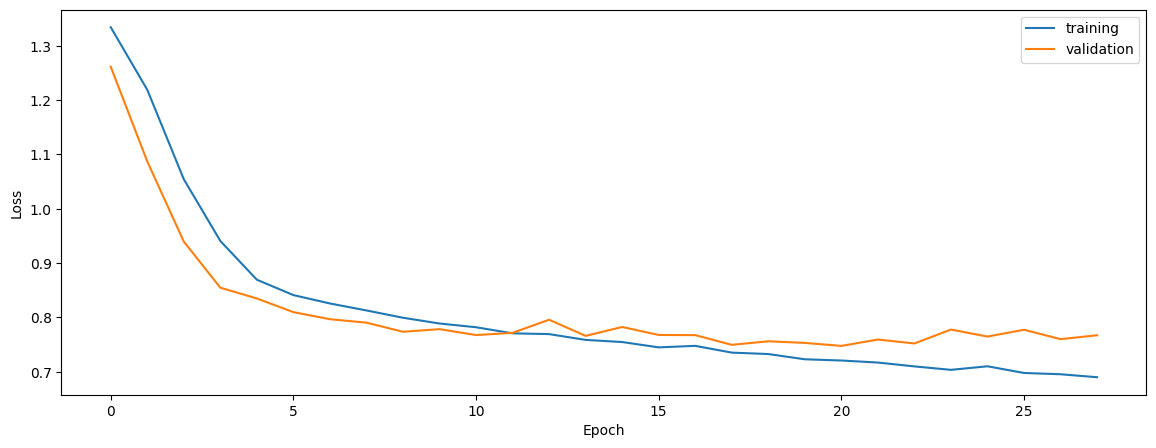

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.7179806527120381
0.6956680625790139
0.679688132028153


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.7179806527120381
0.6956680625790139
0.679688132028153


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.7155885060514722
0.6966824644549763
0.6747450815406928


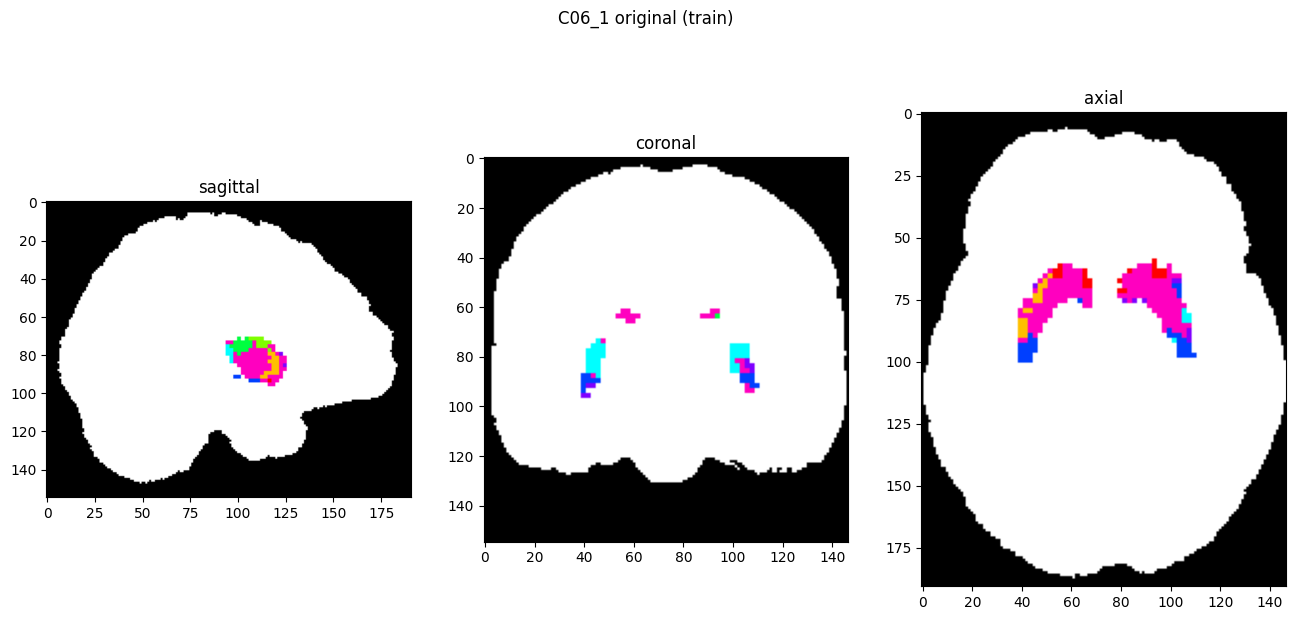

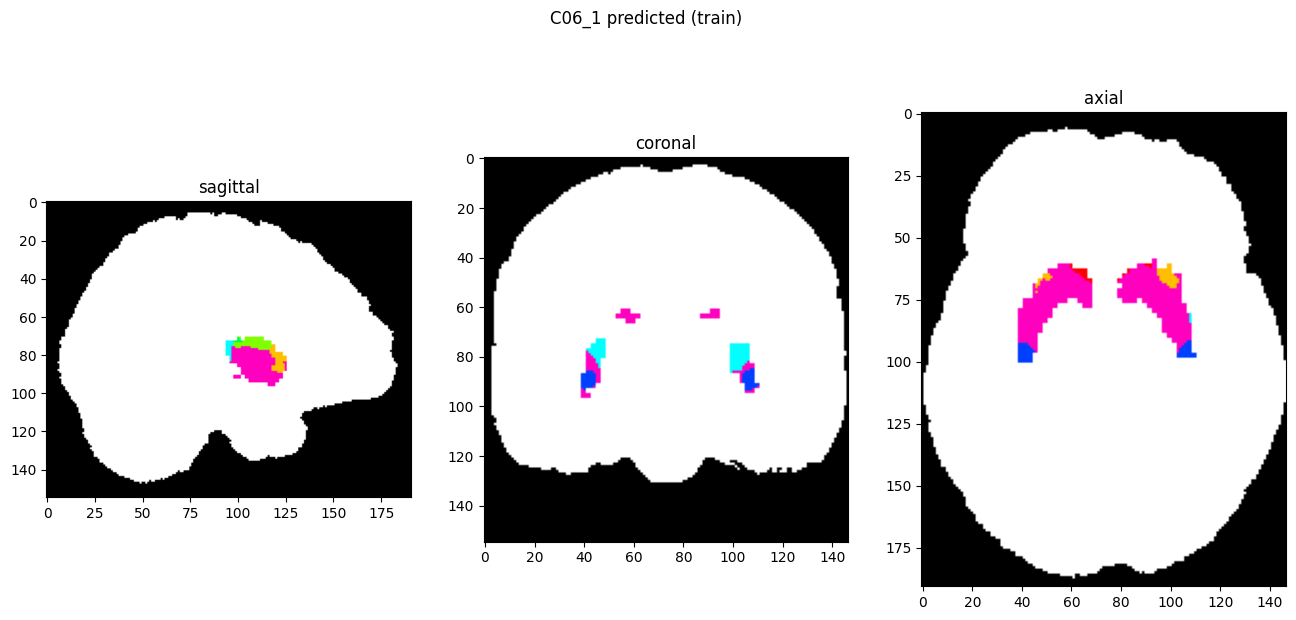

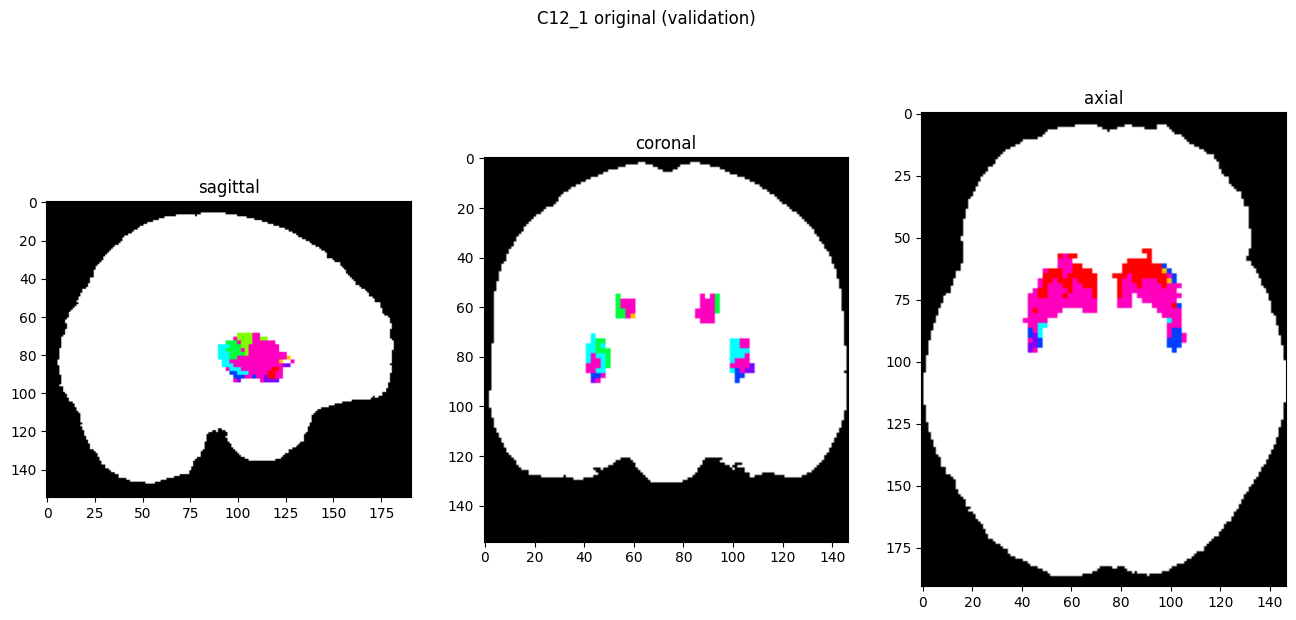

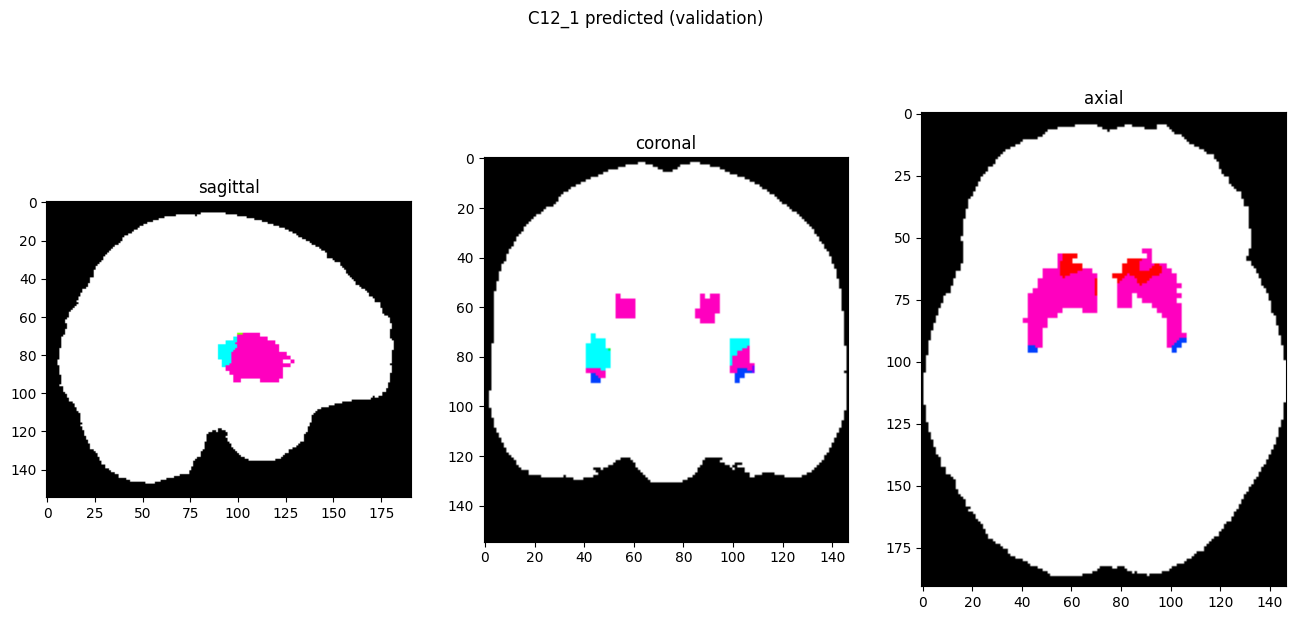

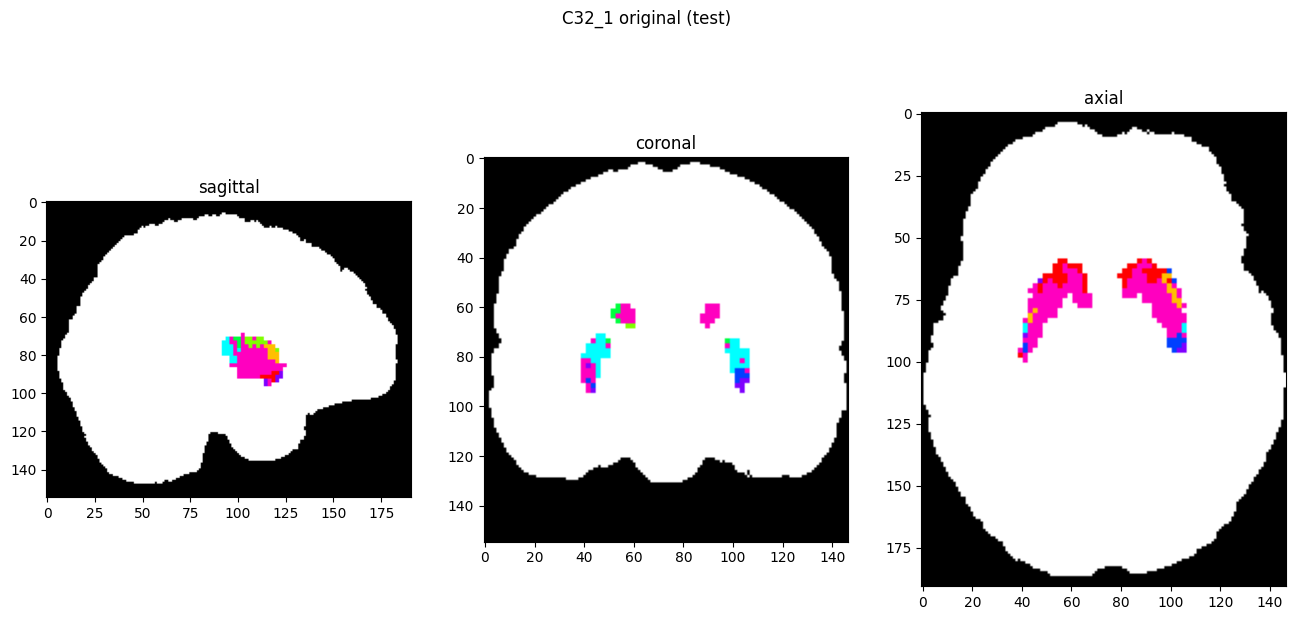

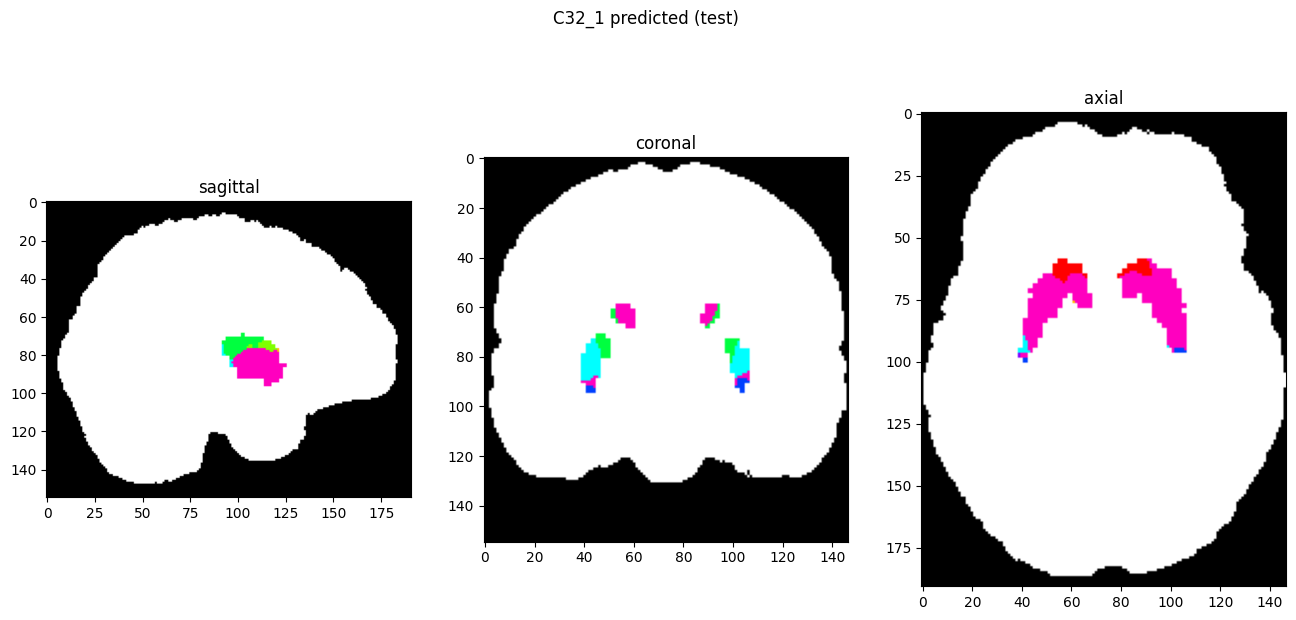

In [10]:
showResults(model, gen, threshold=0)